## Wineteller : Reminder
Hyowon, Seoul 2023 : winetellerwill be ready soon !!!
hellooooooo je ne peux pas écrire en coréen mais c'est pas grave
J'adoreeeeee"ee wowowooa&jizkej oµ®‡ukztj e,dlk

-- Notes\
 home/outside, alone/with people, fancy/casual
balance -> casual 
body -> 
acidity -> 
 romantic <- rose/flower
complexity/oak (tertiary flavors) -> moody
 elegance (everything is restrained yet tasty) -> fancy \
 for the future\
 cozy -> 'warm' flavors 
 outdoor -> 'cold' flavors
 netflix and chill -> something that reminds of the diversity of netflix      


# Data prep 

## vectorized_data.csv

In [ ]:
%%time

#python
import pandas as pd
import string
import os
import time
import pickle

#compute cell-executing time
#from tqdm.notebook import trange, tqdm

#new import from pypi doc
from tqdm import tqdm

#text preprocessing
from operator import itemgetter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter, OrderedDict

#nlp modeling
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

#clusterization 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
#from matplotlib import pyplot as plt

## Load Data

file_location = '/Users/hyunoochang/code/chyunoo/wineteller/raw_data/winemag-data_first150k.csv'

data = pd.read_csv(file_location, index_col='Unnamed: 0')
print(data.shape)

data.head(5)

## Clean Data

data.isna().sum()

data = data.drop_duplicates(subset=["description"])
data.shape

#### Preprocess text for w2v model training ####

#tokenization : reviews -> sentences

reviews_list = list(data['description'])
reviews_list = [str(r) for r in reviews_list]

sentences_tokenized=[]
for review in tqdm(reviews_list) :
    sentences_tokenized.append(sent_tokenize(review))
sentences_tokenized = [item for sublist in sentences_tokenized for item in sublist]

#normalization : remove stopwords and punctuation + tokenize sentences into words

stop_words = set(stopwords.words('english')) 

punctuation_table = str.maketrans({key: None for key in string.punctuation})
sno = SnowballStemmer('english')

def normalize_text(raw_text):
    try:
        word_list = word_tokenize(raw_text)
        normalized_sentence = []
        for w in word_list:
            try:
                w = str(w)
                lower_case_word = str.lower(w)
                stemmed_word = sno.stem(lower_case_word)
                no_punctuation = stemmed_word.translate(punctuation_table)
                if len(no_punctuation) > 1 and no_punctuation not in stop_words:
                    normalized_sentence.append(no_punctuation)
            except:
                continue
        return normalized_sentence
    except:
        return ''

normalized_sentences = []
for s in tqdm(sentences_tokenized) :
    normalized_text = normalize_text(s)
    normalized_sentences.append(normalized_text)

#retrieve bi-grams and tri-grams from normalized sentences

phrases = Phrases(normalized_sentences)
phrases = Phrases(phrases[normalized_sentences])

ngrams = Phraser(phrases)

phrased_sentences = []
for sent in tqdm(normalized_sentences):
    phrased_sentence = ngrams[sent]
    phrased_sentences.append(phrased_sentence)

full_list_words = [item for sublist in phrased_sentences for item in sublist]

map_location = '/Users/hyunoochang/code/chyunoo/wineteller/raw_data/descriptor_mapping.csv'

descriptor_mapping = pd.read_csv(map_location).set_index('raw descriptor')

def return_mapped_descriptor(word):
    if word in list(descriptor_mapping.index):
        normalized_word = descriptor_mapping['level_3'][word]
        return normalized_word
    else:
        return ""

normalized_sentences = []
for sent in tqdm(phrased_sentences):
    normalized_sentence = []
    for word in sent:
        normalized_word = return_mapped_descriptor(word)
        if normalized_word != "" :
            normalized_sentence.append(str(normalized_word))
        else :
            pass
    normalized_sentences.append(normalized_sentence)

#fit Word2Vec model into corpus 
model = Word2Vec(normalized_sentences, vector_size=300, min_count=1, epochs=15)
print(model)

#model.save('model.bin')

#### Merge with dataset ####

wine_reviews = list(data['description'])

map_location = '/Users/hyunoochang/code/chyunoo/wineteller/raw_data/descriptor_mapping.csv'

descriptor_mapping = pd.read_csv(map_location).set_index('raw descriptor')
descriptor_mapping.head()

def return_descriptor_from_mapping(word):
    if word in list(descriptor_mapping.index):
        descriptor_to_return = descriptor_mapping['level_3'][word]
        return descriptor_to_return

descriptorized_reviews = []
for review in tqdm(wine_reviews):
    normalized_review = normalize_text(review)
    phrased_review = ngrams[normalized_review]
    descriptors_only = [return_descriptor_from_mapping(word) for word in phrased_review]
    no_nones = [str(d) for d in descriptors_only if d is not None]
    descriptorized_review = ' '.join(no_nones)
    descriptorized_reviews.append(descriptorized_review)

#apply Tfidf weights and compute wine review vectors from word vectors

vectorizer = TfidfVectorizer()
X = vectorizer.fit(descriptorized_reviews)

dict_of_tfidf_weightings = dict(zip(X.get_feature_names(), X.idf_))

wine_review_vectors = []
for d in tqdm(descriptorized_reviews):
    descriptor_count = 0
    weighted_review_terms = []
    terms = d.split(' ')
    for term in terms:
        if term in dict_of_tfidf_weightings.keys():
            tfidf_weighting = dict_of_tfidf_weightings[term]
            word_vector = model.wv.get_vector(term).reshape(1, 300)
            weighted_word_vector = tfidf_weighting * word_vector
            weighted_review_terms.append(weighted_word_vector)
            descriptor_count += 1
        else:
            continue
    try:
        review_vector = sum(weighted_review_terms)/len(weighted_review_terms)
    except:
        review_vector = []
    vector_and_count = [terms, review_vector, descriptor_count]
    wine_review_vectors.append(vector_and_count)

#concatenante in new dataset
data['normalized_descriptors'] = list(map(itemgetter(0), wine_review_vectors))
data['review_vector'] = list(map(itemgetter(1), wine_review_vectors))
data['descriptor_count'] = list(map(itemgetter(2), wine_review_vectors))

data.reset_index(inplace=True)

#data = data.drop(columns=["level_0", "index"])

data = data.drop(columns = ["region_1",
                             "region_2",
                             "points",
                             "price",
                             "designation",
                             "winery"])

#destination = "/Users/hyunoochang/code/chyunoo/wineteller/raw_data/preprocessed_data/vectorized_data.csv"

#data.to_csv(destination)

## compressed_data.csv

In [93]:
vectorized = "/Users/hyunoochang/code/chyunoo/wineteller/raw_data/preprocessed_data/vectorized_data.csv"
df_v = pd.read_csv(vectorized)
df_v = df_v[df_v["descriptor_count"]>0] 
df_v = df_v.drop(columns=["Unnamed: 0","review_vector",
                                  "descriptor_count",
                                  "description",
                                  "normalized_descriptors"])

df_v = df_v.fillna('')
print(df_v.memory_usage(deep=True).sum())
df_v["country"] = df_v["country"].astype("category")
df_v["province"] =df_v["province"].astype("category")
df_v["variety"] = df_v["variety"].astype("category")
print(df_v.memory_usage(deep=True).sum())

compressed_path = "/Users/hyunoochang/code/chyunoo/wineteller/raw_data/preprocessed_data/compressed_data.csv"
df_v.to_csv(compressed_path )
#df_c = pd.read_csv(compressed_path, index_col=0,  keep_default_na=False)

20324061


# Test pre normalized text

In [2]:

#with open("phrased_sentences", "wb") as fp:   #Pickling
    #pickle.dump(phrased_sentences, fp)

#import pickle
#with open("normalized_sentences", "wb") as fp:   #Pickling
#    pickle.dump(normalized_sentences, fp)
#
#with open("normalized_sentences", "rb") as fp:   # Unpickling
#    normalized_sentences = pickle.load(fp)
#
#with open("phrased_sentences", "rb") as fp:   # Unpickling
#    phrased_sentences = pickle.load(fp)

In [37]:
%%time
from collections import Counter
flat_list = [item for sublist in tqdm(normalized_sentences) for item in sublist]

# Use Counter to count the frequency of each unique item in the flattened list
item_frequency = Counter(flat_list)

df = pd.DataFrame(list(item_frequency.items()), columns=['Item', 'Frequency'])

df.to_csv("normalized_sentences.csv", index=None)

100%|██████████████████████████████| 270421/270421 [00:00<00:00, 1082568.78it/s]

CPU times: user 251 ms, sys: 173 ms, total: 424 ms
Wall time: 441 ms


In [17]:
%%time
flat_list = [item for sublist in tqdm(phrased_sentences) for item in sublist]

# Use Counter to count the frequency of each unique item in the flattened list
item_frequency = Counter(flat_list)

100%|███████████████████████████████| 270421/270421 [00:00<00:00, 977607.36it/s]

CPU times: user 519 ms, sys: 50 ms, total: 569 ms
Wall time: 583 ms


# Test framework

In [1]:
#### Test framework ####

from scipy import spatial
import numpy as np
import pprint
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import pi

#python
import pandas as pd
import string
import os
import time

#compute cell-executing time
#from tqdm.notebook import trange, tqdm

#new import from pypi doc
from tqdm import tqdm

#text preprocessing
from operator import itemgetter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter, OrderedDict

#nlp modeling
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

#clusterization 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
#from matplotlib import pyplot as plt

model = Word2Vec.load("model.bin")
print(model)
word_vectors = model.wv

#for w in occasion_attributes["fancy"] :
#    print(w in model.wv.index_to_key)

#for i in model.wv.index_to_key :
#    if "bitter" in i : 
#        print(i)

#baseline
occasion_attributes = {"romantic" : ['violet_rose', 'rose_violet','potpourri', 'rosewater',
                       'lavender', 'lilac', 'rose' 'petal', 'feminine', "flower"],#feminine
                       
                       "casual" : ["high_acid","full_bodied", "fruit", "fruit-forward", "medium_bodied", "racy", "tannin"],
                      
                      "moody" : ['wood_age', 'new_wood','oak','oak-driven', 'wood', "vanilla", "brown_butter", "nutty", "maple", "yeast"
                                ],
                      
                      
                      "fancy" : [
                                'refined','elegant',"classy", "opulent", "flashy"
                                  
                                ]}

wd_vecs = dict()
for wd in word_vectors.index_to_key :
    try:
        wd_vec = word_vectors[wd]
        wd_vecs[wd] = wd_vec
    except:
        continue

average_occasion_vecs = dict()
occasion_attributes_distances = dict()
for attribute, keywords in occasion_attributes.items():
    
    all_keyword_vecs = []
    for keyword in keywords:
        try : 
            c_vec = word_vectors[keyword]
            all_keyword_vecs.append(c_vec)
        except : 
            continue
        
    
    avg_attribute_vec = np.average(all_keyword_vecs, axis=0)
    average_occasion_vecs[attribute] = avg_attribute_vec
    
    attribute_distances = dict()
    for k, v in wd_vecs.items():
        similarity = 1- spatial.distance.cosine(avg_attribute_vec, v)
        attribute_distances[k] = similarity
        
    occasion_attributes_distances[attribute] = attribute_distances   
    
occasion_attribute_infos = dict()
for key, value in occasion_attributes.items():
    dict_attribute = dict()
    farthest = min(occasion_attributes_distances[key], key=occasion_attributes_distances[key].get)
    farthest_distance = occasion_attributes_distances[key][farthest]
    closest = max(occasion_attributes_distances[key], key=occasion_attributes_distances[key].get)
    closest_distance = occasion_attributes_distances[key][closest]
    print(key, farthest, closest)
    dict_attribute['farthest'] = farthest_distance
    dict_attribute['closest'] = closest_distance
    dict_attribute['average_vec'] = average_occasion_vecs[key]
    occasion_attribute_infos[key] = dict_attribute

d_romantic = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["romantic"], v)
    d_romantic[a] = distance

d_casual = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["casual"], v)
    d_casual[a] = distance

d_moody = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["moody"], v)
    d_moody[a] = distance 

d_fancy = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["fancy"], v)
    d_fancy[a] = distance

#d_outdoor = dict()
#for a, v in average_occasion_vecs.items() : 
#    distance = 1 - spatial.distance.cosine(average_occasion_vecs["drunk"], v)
#    d_outdoor[a] = distance
    

    
d_list = [d_romantic, d_casual, d_moody, d_fancy] #d_outdoor
d_attributes = dict()
for a, d in zip(occasion_attributes.keys(), d_list) : 
    d_attributes[a] = d

pprint.pprint(d_attributes)

sorted_dict = {
    key: dict(sorted(sub_dict.items(), key=lambda item: item[1], reverse=True))
    for key, sub_dict in occasion_attributes_distances.items()
}

for a in occasion_attributes.keys() : 
    print(list(sorted_dict[a].items())[:10])


#example 
#word_vectors.most_similar(positive='inky', topn=20)

Word2Vec<vocab=625, vector_size=300, alpha=0.025>
romantic bite lilac
casual walnut medium_bodied
moody prickly wood
fancy hollow refined
{'casual': {'casual': 1,
            'fancy': 0.09507822245359421,
            'moody': -0.06205185130238533,
            'romantic': -0.019163809716701508},
 'fancy': {'casual': 0.09507822245359421,
           'fancy': 1,
           'moody': 0.1957806944847107,
           'romantic': 0.21934109926223755},
 'moody': {'casual': -0.06205185130238533,
           'fancy': 0.1957806944847107,
           'moody': 1,
           'romantic': -0.11601012200117111},
 'romantic': {'casual': -0.019163809716701508,
              'fancy': 0.21934109926223755,
              'moody': -0.11601012200117111,
              'romantic': 1}}
[('lilac', 0.8702071309089661), ('violet_rose', 0.8325842022895813), ('lavender', 0.8246857523918152), ('potpourri', 0.8200422525405884), ('rose_violet', 0.7974104285240173), ('petal', 0.7938634753227234), ('feminine', 0.776771008968353

In [17]:
occasion_attribute_infos

{'romantic': {'farthest': -0.3419085144996643,
  'closest': 0.8702071309089661,
  'average_vec': array([ 0.00600799,  0.2611088 ,  0.09721318, -0.02022963,  0.0941189 ,
         -0.16538292, -0.47792718,  0.20112452,  0.22354378, -0.28371435,
          0.10056514,  0.01458802, -0.04096095,  0.02647667,  0.05755308,
         -0.03738467,  0.11804092,  0.1662333 ,  0.34002313,  0.12897699,
         -0.35007665,  0.07178849,  0.02362566,  0.04280888, -0.15014556,
          0.04174089, -0.23174441,  0.26455492, -0.18995234,  0.02608071,
          0.23208128,  0.05895049,  0.2308149 , -0.1528266 ,  0.0357085 ,
          0.36606592, -0.15363269, -0.05374323, -0.10768297,  0.11032765,
          0.13951857,  0.4451743 , -0.3625595 ,  0.02030791,  0.07139824,
          0.2583676 , -0.04145728,  0.18225603,  0.02125236,  0.1898417 ,
          0.24330893, -0.10100611,  0.22441822,  0.03616647,  0.33850032,
          0.05107286, -0.22662048,  0.0226813 , -0.01955911, -0.04194915,
          0.22536

In [16]:
average_occasion_vecs

{'romantic': array([ 0.00600799,  0.2611088 ,  0.09721318, -0.02022963,  0.0941189 ,
        -0.16538292, -0.47792718,  0.20112452,  0.22354378, -0.28371435,
         0.10056514,  0.01458802, -0.04096095,  0.02647667,  0.05755308,
        -0.03738467,  0.11804092,  0.1662333 ,  0.34002313,  0.12897699,
        -0.35007665,  0.07178849,  0.02362566,  0.04280888, -0.15014556,
         0.04174089, -0.23174441,  0.26455492, -0.18995234,  0.02608071,
         0.23208128,  0.05895049,  0.2308149 , -0.1528266 ,  0.0357085 ,
         0.36606592, -0.15363269, -0.05374323, -0.10768297,  0.11032765,
         0.13951857,  0.4451743 , -0.3625595 ,  0.02030791,  0.07139824,
         0.2583676 , -0.04145728,  0.18225603,  0.02125236,  0.1898417 ,
         0.24330893, -0.10100611,  0.22441822,  0.03616647,  0.33850032,
         0.05107286, -0.22662048,  0.0226813 , -0.01955911, -0.04194915,
         0.22536466, -0.11512229, -0.0388378 ,  0.4134224 , -0.02729463,
        -0.03464282, -0.02877237, -0.23

In [15]:
occasion_attribute_infos

{'romantic': {'farthest': -0.3419085144996643,
  'closest': 0.8702071309089661,
  'average_vec': array([ 0.00600799,  0.2611088 ,  0.09721318, -0.02022963,  0.0941189 ,
         -0.16538292, -0.47792718,  0.20112452,  0.22354378, -0.28371435,
          0.10056514,  0.01458802, -0.04096095,  0.02647667,  0.05755308,
         -0.03738467,  0.11804092,  0.1662333 ,  0.34002313,  0.12897699,
         -0.35007665,  0.07178849,  0.02362566,  0.04280888, -0.15014556,
          0.04174089, -0.23174441,  0.26455492, -0.18995234,  0.02608071,
          0.23208128,  0.05895049,  0.2308149 , -0.1528266 ,  0.0357085 ,
          0.36606592, -0.15363269, -0.05374323, -0.10768297,  0.11032765,
          0.13951857,  0.4451743 , -0.3625595 ,  0.02030791,  0.07139824,
          0.2583676 , -0.04145728,  0.18225603,  0.02125236,  0.1898417 ,
          0.24330893, -0.10100611,  0.22441822,  0.03616647,  0.33850032,
          0.05107286, -0.22662048,  0.0226813 , -0.01955911, -0.04194915,
          0.22536

In [14]:
d_list

[{'romantic': 1,
  'casual': -0.019163809716701508,
  'moody': -0.11601012200117111,
  'fancy': 0.21934109926223755},
 {'romantic': -0.019163809716701508,
  'casual': 1,
  'moody': -0.06205185130238533,
  'fancy': 0.09507822245359421},
 {'romantic': -0.11601012200117111,
  'casual': -0.06205185130238533,
  'moody': 1,
  'fancy': 0.1957806944847107},
 {'romantic': 0.21934109926223755,
  'casual': 0.09507822245359421,
  'moody': 0.1957806944847107,
  'fancy': 1}]

In [136]:
for a in occasion_attributes.keys() : 
    if a == "fancy" : 
        print(list(sorted_dict[a].items())[:30])

[('refined', 0.7379996180534363), ('flashy', 0.6570696234703064), ('elegant', 0.6469594836235046), ('opulent', 0.6331062316894531), ('voluptuous', 0.6007290482521057), ('classy', 0.5881659388542175), ('luxurious', 0.5419113636016846), ('mass', 0.5406475067138672), ('complex', 0.5147417783737183), ('complicated', 0.4999610483646393), ('asian_spice', 0.4913279116153717), ('finessed', 0.46738526225090027), ('lavish', 0.4646185636520386), ('rich', 0.4538593590259552), ('lush', 0.4427560567855835), ('gingerbread', 0.4317964017391205), ('tangerine_peel', 0.42106249928474426), ('anise', 0.42008209228515625), ('exuberant', 0.41759225726127625), ('polished', 0.4144240915775299), ('lengthy', 0.41334760189056396), ('sandalwood', 0.40766245126724243), ('cherry_liqueur', 0.4058015048503876), ('velvety', 0.4032082259654999), ('new_oak', 0.39937740564346313), ('depth', 0.395638644695282), ('dr_pepper', 0.3897191286087036), ('sleek', 0.38721567392349243), ('mulberry', 0.38474857807159424), ('heady', 0

# Train Knn model

In [77]:
%%time
destination = "/Users/hyunoochang/code/chyunoo/wineteller/raw_data/preprocessed_data/vectorized_data.csv"
data = pd.read_csv(destination)
print(data.shape)

CPU times: user 4.4 s, sys: 898 ms, total: 5.3 s
Wall time: 5.6 s


In [212]:
## Define a custom function to check the dimension of each array
#def check_array_shape(arr):
#    return arr.shape == (300,1)   # Change the dimension you want to check fo
#
## Use the apply method to apply the custom function to each element in the Series
#incorrect_dimensions = reshaped_array_list.apply(lambda x: not check_array_shape(x))

In [13]:
import numpy as np
import pickle

def save_model_knn(model: NearestNeighbors = None) -> None:
    """
    persist trained model
    """
    if model is not None :
        model_path= "/Users/hyunoochang/code/chyunoo/wineteller/notebooks/trained_knn_0906.model"

        with open(model_path, "wb") as file:
            pickle.dump(model, file)
            print(f"\n✅ knn model saved locally at {model_path}")
            file.close()

    return None


df = data[data["descriptor_count"]>0] 
print(df.shape)
df["review_vector"]=[np.float_(i[2:-2].split()) for i in df["review_vector"]]
review_vectors_listed = list(df["review_vector"])
#reshaped_array_list = [arr.reshape(-1, 1) for arr in review_vectors_listed]
knn = NearestNeighbors(n_neighbors=10, algorithm="brute", metric="cosine")
knn_trained = knn.fit(np.array(review_vectors_listed))
print(knn_trained)

save_model_knn(knn_trained)

/var/folders/qt/dqfmgcdd30d3k8fh1t4zqmlw0000gn/T/ipykernel_9756/817157115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["review_vector"]=[np.float_(i[2:-2].split()) for i in df["review_vector"]]


NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)


# Score each wine with framework


## Run framework

In [10]:
from scipy import spatial
import numpy as np
import pprint
import matplotlib.pyplot as plt
from matplotlib import gridspec
from math import pi

#python
import pandas as pd
import string
import os
import time

#compute cell-executing time
#from tqdm.notebook import trange, tqdm

#new import from pypi doc
from tqdm import tqdm

#text preprocessing
from operator import itemgetter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter, OrderedDict

#nlp modeling
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

#clusterization 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
#from matplotlib import pyplot as plt

model = Word2Vec.load("model.bin")
print(model)
word_vectors = model.wv

#for w in occasion_attributes["fancy"] :
#    print(w in model.wv.index_to_key)

#for i in model.wv.index_to_key :
#    if "bitter" in i : 
#        print(i)

#baseline
occasion_attributes = {"romantic" : ['violet_rose', 'rose_violet','potpourri', 'rosewater',
                       'lavender', 'lilac', 'rose' 'petal', 'feminine', "flower"],#feminine
                       
                       "casual" : ["high_acid","full_bodied", "fruit", "fruit-forward", "medium_bodied", "racy", "tannin"],
                      
                      "moody" : ['wood_age', 'new_wood','oak','oak-driven', 'wood', "vanilla", "brown_butter", "nutty", "maple", "yeast"
                                ],
                      
                      
                      "fancy" : [
                                'refined','elegant',"classy", "opulent", "flashy"
                                  
                                ]}

wd_vecs = dict()
for wd in word_vectors.index_to_key :
    try:
        wd_vec = word_vectors[wd]
        wd_vecs[wd] = wd_vec
    except:
        continue

average_occasion_vecs = dict()
occasion_attributes_distances = dict()
for attribute, keywords in occasion_attributes.items():
    
    all_keyword_vecs = []
    for keyword in keywords:
        try : 
            c_vec = word_vectors[keyword]
            all_keyword_vecs.append(c_vec)
        except : 
            continue
        
    
    avg_attribute_vec = np.average(all_keyword_vecs, axis=0)
    average_occasion_vecs[attribute] = avg_attribute_vec
    
    attribute_distances = dict()
    for k, v in wd_vecs.items():
        similarity = 1- spatial.distance.cosine(avg_attribute_vec, v)
        attribute_distances[k] = similarity
        
    occasion_attributes_distances[attribute] = attribute_distances   
    
occasion_attribute_infos = dict()
for key, value in occasion_attributes.items():
    dict_attribute = dict()
    farthest = min(occasion_attributes_distances[key], key=occasion_attributes_distances[key].get)
    farthest_distance = occasion_attributes_distances[key][farthest]
    closest = max(occasion_attributes_distances[key], key=occasion_attributes_distances[key].get)
    closest_distance = occasion_attributes_distances[key][closest]
    print(key, farthest, closest)
    dict_attribute['farthest'] = farthest_distance
    dict_attribute['closest'] = closest_distance
    dict_attribute['average_vec'] = average_occasion_vecs[key]
    occasion_attribute_infos[key] = dict_attribute

d_romantic = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["romantic"], v)
    d_romantic[a] = distance

d_casual = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["casual"], v)
    d_casual[a] = distance

d_moody = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["moody"], v)
    d_moody[a] = distance 

d_fancy = dict()
for a, v in average_occasion_vecs.items() : 
    distance = 1 - spatial.distance.cosine(average_occasion_vecs["fancy"], v)
    d_fancy[a] = distance

#d_outdoor = dict()
#for a, v in average_occasion_vecs.items() : 
#    distance = 1 - spatial.distance.cosine(average_occasion_vecs["drunk"], v)
#    d_outdoor[a] = distance
    

    
d_list = [d_romantic, d_casual, d_moody, d_fancy] #d_outdoor
d_attributes = dict()
for a, d in zip(occasion_attributes.keys(), d_list) : 
    d_attributes[a] = d

pprint.pprint(d_attributes)

sorted_dict = {
    key: dict(sorted(sub_dict.items(), key=lambda item: item[1], reverse=True))
    for key, sub_dict in occasion_attributes_distances.items()
}

for a in occasion_attributes.keys() : 
    print(list(sorted_dict[a].items())[:10])


#example 
#word_vectors.most_similar(positive='inky', topn=20)

Word2Vec<vocab=625, vector_size=300, alpha=0.025>
romantic bite lilac
casual walnut medium_bodied
moody prickly wood
fancy hollow refined
{'casual': {'casual': 1,
            'fancy': 0.09507822245359421,
            'moody': -0.06205185130238533,
            'romantic': -0.019163809716701508},
 'fancy': {'casual': 0.09507822245359421,
           'fancy': 1,
           'moody': 0.1957806944847107,
           'romantic': 0.21934109926223755},
 'moody': {'casual': -0.06205185130238533,
           'fancy': 0.1957806944847107,
           'moody': 1,
           'romantic': -0.11601012200117111},
 'romantic': {'casual': -0.019163809716701508,
              'fancy': 0.21934109926223755,
              'moody': -0.11601012200117111,
              'romantic': 1}}
[('lilac', 0.8702071309089661), ('violet_rose', 0.8325842022895813), ('lavender', 0.8246857523918152), ('potpourri', 0.8200422525405884), ('rose_violet', 0.7974104285240173), ('petal', 0.7938634753227234), ('feminine', 0.776771008968353

## Create scores

In [11]:
%%time
# load dataset and review vectors
destination = "/Users/hyunoochang/code/chyunoo/wineteller/raw_data/preprocessed_data/vectorized_data.csv"
data = pd.read_csv(destination)
data["review_vector"]=[np.float_(i[2:-2].split()) for i in data["review_vector"]]
data = data[data["descriptor_count"]>0]
print(data["review_vector"][0].shape)

# define relevant functions
def minmax_scaler(val, minval, maxval):
    val = max(min(val, maxval), minval)
    normalized_val = (val - minval)/(maxval - minval)
    return normalized_val

def attribute_values(attribute, wine_vector):
    attribute_value = average_occasion_vecs[attribute]
    similarity = 1 - spatial.distance.cosine(attribute_value, wine_vector)
    # scale the similarity using our minmax scaler
    scaled_similarity = minmax_scaler(similarity, occasion_attribute_infos[attribute]['farthest'], 
                                      occasion_attribute_infos[attribute]['closest'])
    similarity_and_scaled = (similarity, scaled_similarity)
    return similarity_and_scaled

def return_score_values(wine_vector):
    wine_scores = dict()
    for i, wine in enumerate(wine_vector) : 
        attribute_scores = dict()
        for attribute in occasion_attributes.keys():
            attribute_scores[attribute] = attribute_values(attribute, wine)   
        wine_scores[i] = attribute_scores
    return wine_scores

# score each wine with framework
score_values = return_score_values(data["review_vector"])

# create score columns in dataset
romantic = dict()
moody = dict()
casual = dict()
fancy = dict()

for key, values in score_values.items():
    romantic[key] = values["romantic"][-1]
    moody[key] = values["moody"][-1]
    casual[key] = values["casual"][-1]
    fancy[key] = values["fancy"][-1]
    
romantic_dict = dict(zip(romantic.keys(), romantic.values()))
moody_dict = dict(zip(moody.keys(), moody.values()))
casual_dict = dict(zip(casual.keys(), casual.values()))
fancy_dict = dict(zip(fancy.keys(), fancy.values()))

data = data.reset_index()
data["romantic_sc"] = data.index.map(romantic_dict)
data["moody_sc"] = data.index.map(moody_dict)
data["casual_sc"] = data.index.map(casual_dict)
data["fancy_sc"] = data.index.map(fancy_dict)

# score normalized distributions 
romantic_thresholds = [0,data.romantic_sc.quantile(0.1), data.romantic_sc.quantile(0.7), data.romantic_sc.quantile(0.97),1]
norm_labels = ["1","2","3","4"] 
data["romantic_sc_norm"] = pd.cut(data["romantic_sc"], bins=romantic_thresholds, labels=norm_labels, include_lowest=True)

casual_thresholds = [0,data.casual_sc.quantile(0.02), data.casual_sc.quantile(0.18), data.casual_sc.quantile(0.8),1]
norm_labels = ["1","2","3","4"] 
data["casual_sc_norm"] = pd.cut(data["casual_sc"], bins=casual_thresholds, labels=norm_labels, include_lowest=True)

fancy_thresholds = [0,data.fancy_sc.quantile(0.02), data.fancy_sc.quantile(0.2), data.fancy_sc.quantile(0.8),1]
norm_labels = ["1","2","3","4"] 
data["fancy_sc_norm"] = pd.cut(data["fancy_sc"], bins=fancy_thresholds, labels=norm_labels, include_lowest=True)

moody_thresholds = [0,data.moody_sc.quantile(0.05), data.moody_sc.quantile(0.4), data.moody_sc.quantile(0.95),1]
norm_labels = ["1","2","3","4"] 
data["moody_sc_norm"] = pd.cut(data["moody_sc"], bins=moody_thresholds, labels=norm_labels, include_lowest=True)

data.moody_sc_norm = data.moody_sc_norm.astype(int)
data.romantic_sc_norm = data.romantic_sc_norm.astype(int)
data.fancy_sc_norm = data.fancy_sc_norm.astype(int)
data.casual_sc_norm = data.casual_sc_norm.astype(int)

(300,)
CPU times: user 35.1 s, sys: 1.87 s, total: 36.9 s
Wall time: 39.9 s


# Visualize words space

In [6]:
#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt
#%matplotlib inline
#
#def tsne_plot(model):
#    "Creates and TSNE model and plots it"
#    labels = []
#    tokens = []
#
#    for word in model.wv.index_to_key:
#        tokens.append(model.wv[word])
#        labels.append(word)
#    
#    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
#    new_values = tsne_model.fit_transform(tokens)
#
#    x = []
#    y = []
#    for value in new_values:
#        x.append(value[0])
#        y.append(value[1])
#        
#    plt.figure(figsize=(16, 16)) 
#    for i in range(len(x)):
#        plt.scatter(x[i],y[i])
#        plt.annotate(labels[i],
#                     xy=(x[i], y[i]),
#                     xytext=(5, 2),
#                     textcoords='offset points',
#                     ha='right',
#                     va='bottom')
#    plt.show()
#
#%%time
#
#tsne_plot(model)

# Visualize wines' attributes

{'romantic': ['violet_rose', 'rose_violet', 'potpourri', 'rosewater', 'lavender', 'lilac', 'rosepetal', 'feminine', 'flower'], 'moody': ['wood_age', 'new_wood', 'oak', 'oak-driven', 'wood', 'vanilla', 'brown_butter', 'nutty', 'maple', 'yeast'], 'casual': ['high_acid', 'full_bodied', 'fruit', 'fruit-forward', 'medium_bodied', 'racy', 'tannin'], 'fancy': ['refined', 'elegant', 'classy', 'opulent', 'flashy']}
30.0 7.0
angles : [0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0]
values : [0.6507548018314615, 0.4006110447057839, 0.6215187171753727, 0.7379610572617932]
{'romantic_sc': 0.6507548018314615, 'moody_sc': 0.4006110447057839, 'casual_sc': 0.6215187171753727, 'fancy_sc': 0.7379610572617932} 81001
1.4091503267973857 6.739130434782609
angles : [0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0]
values : [0.4012384357507312, 0.6031799892297671, 0.7532546183252564, 0.7212380752943905]
{'romantic_sc': 0.4012384357507312, 'moody_sc': 0.6031799892297671, 'ca

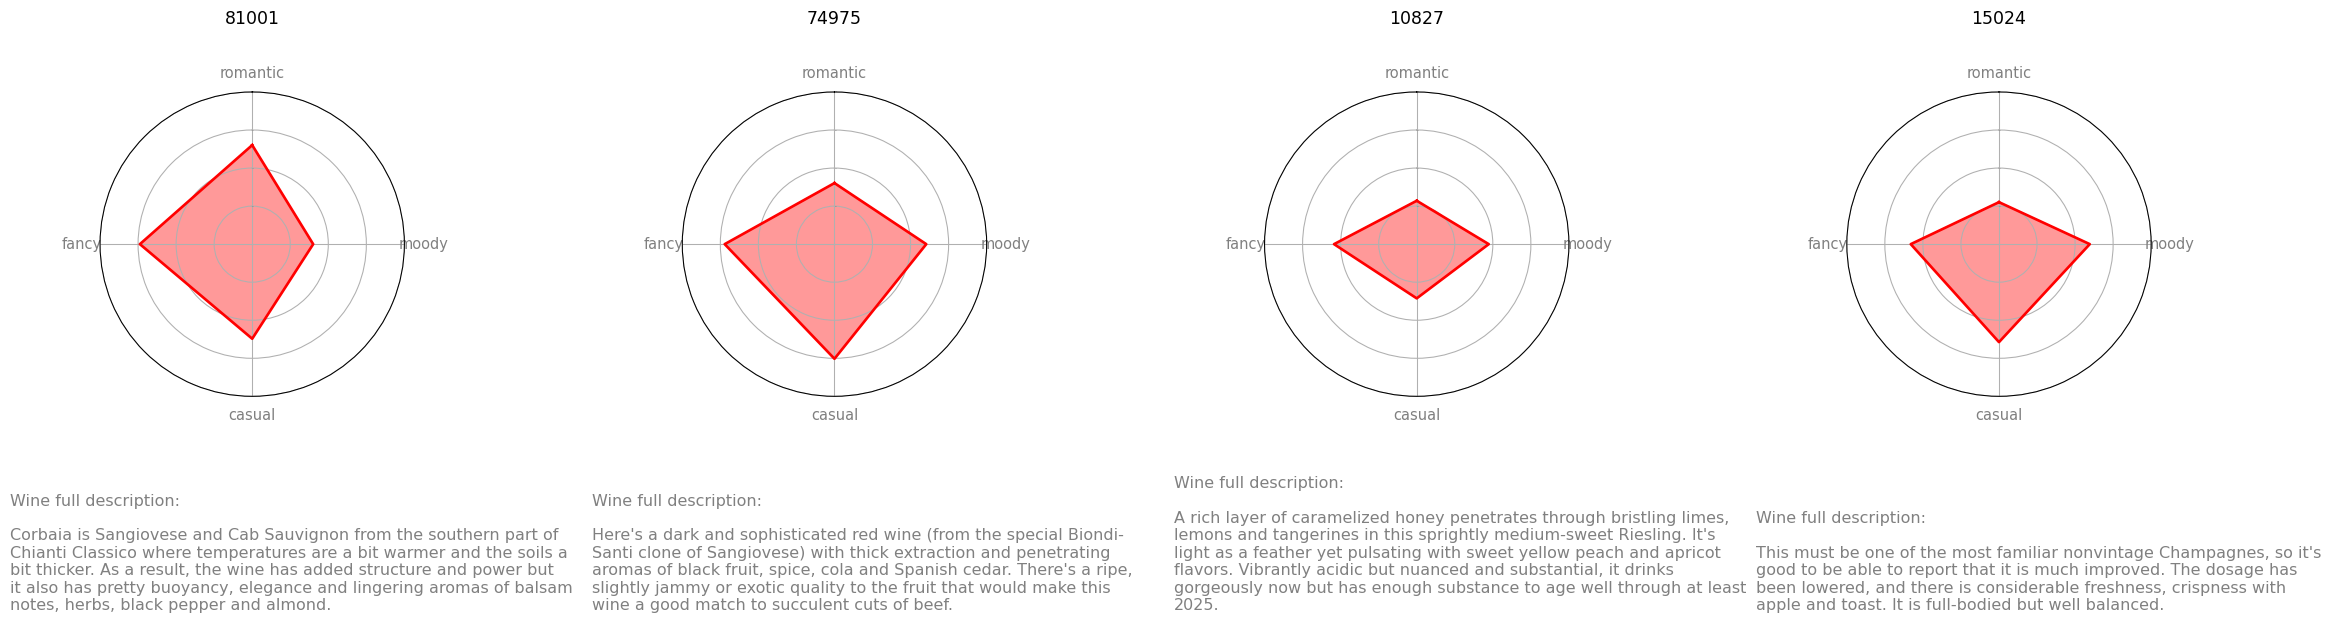

In [4]:
desired_order_list = ["romantic", "moody", "casual", "fancy"]

occasion_attributes = {k: occasion_attributes[k] for k in desired_order_list}
print(occasion_attributes)

def make_spider(gs, n, data, title, color):
    
    # number of variable
    categories = list(occasion_attributes.keys())
    N = len(categories)
    

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    print(f"angles : {angles}")
    # Initialise the spider plot
    ax = plt.subplot(gs[n], polar=True,)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25","0.50","0.75", "1.00"], color="grey", size=0)
    plt.ylim(0, 1)

    # Ind1
    values = list(data.values())
    print(f"values : {values}")
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    # Insert a line break in the title if needed
    title_split = str(title).split(',')
    new_title = []
    for number, word in enumerate(title_split):
        if (number % 2) == 0 and number > 0:
            updated_word = '\n' + word.strip()
            new_title.append(updated_word)
        else:
            updated_word = word.strip()
            new_title.append(updated_word)
    new_title = ', '.join(new_title)
    
    title_incl_pairing_type = new_title

    
    plt.title(title_incl_pairing_type, size=13, color='black', y=1.2)

#def create_text(gs, n, pairing_description):
#    ax = plt.subplot(gs[n])
#    
#    ax.set_xticks([])
#    ax.set_yticks([])
#    for spine in ax.spines.values():
#        spine.set_visible(False)
#    ax.invert_yaxis()
#    
#    text = f'Wine full description:\n\n{pairing_description}'
#    ax.text(x=0, y=1, s=text, fontsize=12, color='grey', multialignment='center')

import textwrap


def create_text(gs, n, pairing_description):
    ax = plt.subplot(gs[n])
    ax_h, ax_w = ax.bbox.height/72, ax.bbox.width/72
    print(ax_h, ax_w)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    
    #max_width = ax.get_position().width
    #ax.get_position().width * gs.get_figwidth() * plt.rcParams['figure.figsize'][0]
    
    # Manually break the text into multiple lines
    lines = textwrap.wrap(pairing_description)
    #lines = textwrap.wrap(pairing_description, width=ax_w)

    # Join the lines with newline characters
    wrapped_text = '\n'.join(lines)

    # Display the wrapped text vertically
    text = f'Wine full description:\n\n{wrapped_text}'
    ax.text(x=0, y=1, s=text, fontsize=12, color='grey')

"""
pairing_wines = list of wine id/name
pairing_occasion_attributes =dict of occasion attributes of each wine
pairing_description = list of wine descriptions
"""
def plot_wine_recommendations(pairing_wines, pairing_occasion_attributes, pairing_description): 

    subplot_rows = 3
    subplot_columns = 4
    fig = plt.figure(figsize=(30, 7), dpi=96)
    fig_height, fig_width = fig.get_size_inches()
    print(fig_height, fig_width)

    gs = gridspec.GridSpec(3, 4, height_ratios=[3, 0.5, 1]) 

    spider_nr = 0
    number_line_nr = 4
    descriptor_nr = 8

    for w in range(4):
        #print(pairing_occasion_attributes[w], pairing_wines[w])
        make_spider(gs, spider_nr, pairing_occasion_attributes[w], pairing_wines[w], 'red')
        print(pairing_occasion_attributes[w], pairing_wines[w])
        create_text(gs, descriptor_nr, pairing_description[w])
        spider_nr += 1
        number_line_nr += 1
        descriptor_nr += 1

sample = data.sample(4)

pairing_id = list(sample.index)
pairing_id

occasion_scores = data.loc[pairing_id, ["romantic_sc", "moody_sc", "casual_sc", "fancy_sc"]]
occasion_scores 

pairing_occasion_attributes = occasion_scores[["romantic_sc", "moody_sc", "casual_sc", "fancy_sc"]].to_dict('records')
pairing_occasion_attributes

pairing_description = list(data.loc[pairing_id, ["description"]].description)
pairing_description

#pairing_description = [d[:50] for d in pairing_description]

plot_wine_recommendations(pairing_id, pairing_occasion_attributes, pairing_description)

In [6]:
pairing_occasion_attributes

[{'romantic_sc': 0.6507548018314615,
  'moody_sc': 0.4006110447057839,
  'casual_sc': 0.6215187171753727,
  'fancy_sc': 0.7379610572617932},
 {'romantic_sc': 0.4012384357507312,
  'moody_sc': 0.6031799892297671,
  'casual_sc': 0.7532546183252564,
  'fancy_sc': 0.7212380752943905},
 {'romantic_sc': 0.28517828869540895,
  'moody_sc': 0.4731537969074557,
  'casual_sc': 0.3562382129106616,
  'fancy_sc': 0.543310489925794},
 {'romantic_sc': 0.27589798848421687,
  'moody_sc': 0.5964899464185368,
  'casual_sc': 0.643722251424712,
  'fancy_sc': 0.5797085933109988}]

In [5]:
data

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm
0,0,0,US,This tremendous 100% varietal wine hails from ...,California,Cabernet Sauvignon,"['oak', 'juicy', 'cherry', 'fruit', 'caramel',...","[-0.876947284, -1.29380608, -0.580353558, -0.2...",7,0.330745,0.738717,0.766991,0.756505,2,4,4,4
1,1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Northern Spain,Tinta de Toro,"['ripe', 'fig', 'blackberry', 'cassis', 'oak',...","[-0.3248471, -2.3605814, 0.6392344, 0.81448704...",13,0.371280,0.787276,0.718395,0.756321,3,4,3,4
2,2,2,US,Mac Watson honors the memory of a wine once ma...,California,Sauvignon Blanc,"['complex', 'white', 'dark', 'gold', 'toasted_...","[-0.684077919, -0.158657655, -0.369483083, -1....",10,0.562043,0.588897,0.349290,0.644477,4,3,1,3
3,3,3,US,"This spent 20 months in 30% new French oak, an...",Oregon,Pinot Noir,"['oak', 'fruit', 'dense', 'toast', 'toast', 'c...","[-0.00308552664, -2.27710319, 0.407373935, 1.0...",13,0.350978,0.653178,0.671331,0.742770,3,4,2,4
4,4,4,France,"This is the top wine from La Bégude, named aft...",Provence,Provence red blend,"['dense', 'wood', 'rich', 'concentrated']","[-1.27105033, -1.48233914, 0.270092726, -0.065...",4,0.253620,0.882604,0.546203,0.671408,1,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97767,97816,97816,US,A Syrah-Grenache blend that's dry and rustical...,California,Syrah-Grenache,"['dry', 'rustic', 'tannin', 'gritty', 'chewi',...","[0.546767235, -1.08662069, -0.390977114, 1.912...",9,0.241600,0.401484,0.784851,0.526615,1,2,4,2
97768,97817,97817,Portugal,Oreo eaters will enjoy the aromas of this wine...,Port,Port,"['sweet', 'milk_chocolate']","[-1.8317282, -3.7353883, -0.08215221, 0.722121...",2,0.293042,0.594850,0.629761,0.632411,2,3,2,3
97769,97818,97818,US,"Outside of the vineyard, wines like this are w...",California,Merlot,"['plump', 'baked', 'black_cherry', 'earth', 'd...","[0.463164806, -0.102112591, -0.787160575, 0.55...",6,0.341960,0.499572,0.733501,0.462067,2,1,3,3
97770,97819,97819,Argentina,"Heavy and basic, with melon and pineapple arom...",Mendoza Province,Sauvignon Blanc,"['heavy', 'melon', 'pineapple', 'apple', 'cinn...","[-1.1625822, -1.1422927, -0.21781082, -0.67513...",8,0.229394,0.562983,0.354721,0.451143,1,1,1,3


# Check pairing rules

In [7]:
# Only fancy
data[(data.romantic_sc_norm == 1) & (data.fancy_sc_norm == 4) & (data.casual_sc_norm == 1) & (data.moody_sc_norm == 1)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm


In [21]:
# Only romantic
data[(data.romantic_sc_norm == 4) & (data.fancy_sc_norm == 1) & (data.casual_sc_norm == 1) & (data.moody_sc_norm == 1)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm
34,34,34,US,"The aromas entice with notes of wet stone, hon...",Washington,Chardonnay,"['wet_rocks', 'honeysuckle', 'chamomile', 'sto...","[0.59305096, 2.9422626, 1.0873863, -1.9566987,...",4,0.605605,0.278710,0.338101,0.463344,4,1,1,1
92,92,92,Italy,"Aromas of white spring flower, orchard fruit a...",Veneto,Glera,"['white', 'spring_flower', 'fruit', 'citrus', ...","[-0.25439185, 1.8455625, 0.26482973, -1.247535...",9,0.532598,0.277510,0.241311,0.451910,4,1,1,1
122,122,122,US,A deeper salmon color with elegantly lacy bubb...,California,Sparkling Blend,"['elegant', 'sparkling', 'sparkling', 'waterme...","[-0.819955349, 0.842023909, -0.302919239, -1.1...",16,0.491114,0.341553,0.385095,0.458920,4,1,1,1
149,149,149,US,"This most intriguing white grape, which the La...",California,Malvasia Bianca,"['white', 'sweet', 'bone_dry', 'sugar', 'citru...","[0.02499364, 1.3649739, 0.12720484, -1.1549413...",12,0.477371,0.296221,0.386519,0.475035,4,1,1,1
281,281,281,Italy,"Classic varietal aromas include stone fruit, c...",Northeastern Italy,Sauvignon,"['stone_fruit', 'tomato', 'fresh', 'cut_grass'...","[-0.18998018, 1.3611138, 0.29850486, -0.696166...",11,0.509216,0.254854,0.431585,0.375442,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97578,97627,97627,US,A hint of petrol on the nose designates this a...,New York,Riesling,"['petrol', 'white', 'fruit', 'spice', 'medium_...","[0.4498796, 1.1282912, -0.01733172, -0.982766,...",7,0.482600,0.290563,0.513395,0.425638,4,1,1,1
97609,97658,97658,France,"Plump and succulent, with an appealing persona...",Alsace,Pinot Blanc,"['melon', 'peach', 'rocks']","[-1.91570604, 1.71299899, 1.64425278, -1.56264...",3,0.481689,0.302459,0.286659,0.456191,4,1,1,1
97675,97724,97724,Australia,This is a lighter-style Chard that's pleasing ...,South Australia,Chardonnay,"['light_bodied', 'nut', 'flower', 'white', 'st...","[-0.24697897, 2.0062888, -0.30423155, -0.51093...",7,0.485712,0.328469,0.234310,0.399137,4,1,1,1
97691,97740,97740,US,"A dry, Alsatian-style Riesling with aromas of ...",New York,Riesling,"['dry', 'petrol', 'meat', 'fruit', 'dry', 'oil...","[0.257769167, 1.03379893, 0.83098048, -0.07161...",10,0.469819,0.312682,0.336026,0.351114,4,1,1,1


In [9]:
# Only casual
data[(data.romantic_sc_norm == 1) & (data.fancy_sc_norm == 1) & (data.casual_sc_norm == 4) & (data.moody_sc_norm == 1)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm
56,56,56,France,"Delicious while also young and textured, this ...",Loire Valley,Sauvignon Blanc,"['minerality', 'citrus', 'green', 'fruit', 'ti...","[0.085985817, 0.861501634, 0.435762793, -0.285...",6,0.224968,0.314106,0.767958,0.350355,1,1,4,1
497,497,497,US,Fruit from the Momtazi vineyard often has a st...,Oregon,Pinot Noir,"['fruit', 'herb', 'tart', 'cranberry', 'tight'...","[0.0982890353, 1.15042078, -0.420842588, -0.17...",10,0.235474,0.244053,0.909482,0.472616,1,1,4,1
725,725,725,Argentina,Raspy berry and plum aromas lead to a palate d...,Mendoza Province,Malbec,"['raspy', 'berry', 'plum', 'sharp', 'berry', '...","[1.4862353, 0.45336834, -0.768404, 0.56320125,...",6,0.196246,0.298765,0.774356,0.249563,1,1,4,1
730,730,730,Argentina,Narrow berry aromas are angular and punchy. Th...,Mendoza Province,Bordeaux-style Red Blend,"['berry', 'angular', 'punchy', 'hard', 'sharp'...","[1.6720065, 2.1276262, -0.8481334, 0.4196891, ...",7,0.148043,0.165269,0.909949,0.221031,1,1,4,1
856,856,856,US,This is the second vintage release for the est...,Washington,Cabernet Sauvignon,"['high_acid', 'red_fruit', 'berry', 'cherry', ...","[1.730505, 0.32348126, -0.43333253, 1.0794003,...",5,0.276386,0.110936,0.859410,0.269292,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97229,97278,97278,New Zealand,Leans heavily toward the tobacco-herbaceous si...,Hawke's Bay,Merlot,"['lean', 'black_cherry', 'green', 'earth']","[0.604822576, 0.967548013, 0.405241668, 1.7927...",4,0.260865,0.209928,0.860049,0.316683,1,1,4,1
97382,97431,97431,France,"Made from old vines, this ripe, intensely frui...",Loire Valley,Sauvignon Blanc,"['ripe', 'fruit', 'green', 'plum', 'gooseberry...","[0.36811957, 0.9572106, 0.54856867, 0.06599141...",7,0.163673,0.305334,0.860942,0.338462,1,1,4,1
97497,97546,97546,Argentina,"Here's a good but rugged blend of Merlot, Malb...",Mendoza Province,Red Blend,"['smoked_meat', 'rubber', 'red_fruit', 'hard',...","[1.25157857, 0.986983001, 0.159734771, 1.70662...",5,0.260862,0.293294,0.799122,0.260270,1,1,4,1
97741,97790,97790,Argentina,Kind of reedy and covered with a veneer of woo...,Mendoza Province,Merlot,"['reedy', 'wood', 'cherry', 'raspberry', 'lean...","[0.3984925, 0.37681636, -0.05346097, 1.2081627...",6,0.250618,0.318560,0.896129,0.297922,1,1,4,1


In [10]:
# Only moody
data[(data.romantic_sc_norm == 1) & (data.fancy_sc_norm == 1) & (data.casual_sc_norm == 1) & (data.moody_sc_norm == 4)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm
41,41,41,Spain,This comes across wide and expansive as it laz...,Andalucia,Palomino,"['expansive', 'oily', 'hazelnut', 'toffee', 'p...","[-0.44892597, -1.2298955, -0.38531628, -1.0420...",9,0.194068,0.734633,0.204676,0.432709,1,1,1,4
406,406,406,US,Grapes are sourced from both Stagecoach and Hy...,California,Chardonnay,"['funky', 'brine', 'tropical_fruit', 'oak', 'm...","[-0.198455125, -0.584473014, -0.557245374, 0.0...",8,0.152105,0.686392,0.483113,0.400044,1,1,1,4
692,692,692,US,"Ripe fruit and oak loom large in this wine, pr...",California,Chardonnay,"['ripe', 'fruit', 'oak', 'preserved_lemon', 'f...","[-1.35685921, -0.860365689, 0.22529611, -1.126...",11,0.245479,0.611666,0.261302,0.467805,1,1,1,4
787,787,787,US,This wine hails from Lawrence and Antoine Cree...,Washington,Rhône-style White Blend,"['oak', 'oak', 'steel', 'minerality', 'round',...","[-0.01825709, 0.17572692, 0.28001612, -0.20588...",7,0.180184,0.604143,0.398522,0.400827,1,1,1,4
1219,1219,1219,US,This widely available white is unfussy and med...,California,Chardonnay,"['white', 'medium_bodied', 'toast', 'oak', 'ba...","[0.3693266, -0.40872416, -0.2985289, -1.468738...",6,0.256008,0.645459,0.347054,0.457872,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97503,97552,97552,Austria,"Full-bodied, warm and round in the mouth, this...",Wachau,Grüner Veltliner,"['full_bodied', 'warm', 'round', 'honey', 'har...","[-0.9421427, -0.05127321, 0.26118264, -0.34542...",9,0.191697,0.603372,0.343076,0.435799,1,1,1,4
97510,97559,97559,France,"This is a soft, rich Sancerre, coming from the...",Loire Valley,Sauvignon Blanc,"['soft', 'rich', 'warm', 'wood', 'oxidized', '...","[-0.775713563, -0.786371589, -0.0778316259, -0...",8,0.169615,0.832977,0.372974,0.404127,1,1,1,4
97541,97590,97590,US,Bright entry leads to a softer midpalate. A ch...,Washington,Chardonnay,"['bright', 'soft', 'butter_nut', 'popcorn', 's...","[-0.253397673, -0.0825974345, -1.01499271, -0....",8,0.230527,0.684026,0.503740,0.436556,1,1,1,4
97674,97723,97723,Australia,This Chard relies heavily on oak to get its me...,Western Australia,Chardonnay,"['oak', 'gold', 'butterscotch', 'pickled', 'sp...","[-0.8004513, -0.2833381, -0.46165666, -0.63370...",11,0.231465,0.836734,0.355348,0.416562,1,1,1,4


In [11]:
# Perfect score
data[(data.romantic_sc_norm == 4) & (data.fancy_sc_norm == 4) & (data.casual_sc_norm == 4) & (data.moody_sc_norm == 4)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm
176,176,176,Italy,Here's a sleek Sangiovese that opens with scen...,Tuscany,Sangiovese,"['sleek', 'toast', 'oak', 'vanilla', 'blue_flo...","[-0.68738955, -1.6855482, 0.47319818, 0.378104...",12,0.469557,0.638678,0.764705,0.744910,4,4,4,4
815,815,815,US,"Aromas like mint, dried cherry and new oak com...",California,Cabernet Franc,"['mint', 'dry', 'cherry', 'new_oak', 'bright',...","[-0.36874044, -0.9301188, 0.28774232, -0.26408...",11,0.434638,0.696935,0.786493,0.832035,4,4,4,4
865,865,865,France,"This is a wonderfully balanced wine, bursting ...",Alsace,Gewürztraminer,"['ripe', 'spice', 'rich', 'fruit', 'depth', 'm...","[-0.209339678, -0.779462159, 0.00144939625, 0....",6,0.434632,0.658195,0.768443,0.841115,4,4,4,4
1132,1132,1132,Austria,"The floral, vanilla tone of new oak marries wi...",Niederösterreich,Pinot Noir,"['flower', 'vanilla', 'new_oak', 'ripe', 'cher...","[-1.1221757, -1.1096576, 0.27610946, 0.1081576...",12,0.569216,0.619656,0.786566,0.831839,4,4,4,4
1822,1822,1822,US,"Exuberant, ripe fruit flavor energizes this me...",California,Cabernet Sauvignon,"['exuberant', 'ripe', 'fruit', 'medium_bodied'...","[0.0190139506, -0.189978376, 0.133042812, 0.04...",12,0.501699,0.610962,0.897751,0.777687,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92315,92359,92359,Chile,"Ripe as can be, with black plum, earth and cof...",Maule Valley,Carmenère,"['ripe', 'plum', 'earth', 'coffee', 'flower', ...","[-0.37719357, -0.68485254, -0.312677711, 0.198...",12,0.456718,0.649713,0.822843,0.713040,4,4,4,4
94845,94893,94893,New Zealand,"Impressively big, rich and well extracted, wit...",Martinborough,Pinot Noir,"['rich', 'extracted', 'full_bodied', 'black_ch...","[-0.30196306, -1.1943108, 0.10734185, 0.391302...",12,0.446552,0.611247,0.817199,0.768586,4,4,4,4
95147,95195,95195,US,Serious juice. This is perfectly ripened Washi...,Washington,Syrah,"['juicy', 'bright', 'fruit', 'spice', 'concent...","[-0.72048163, -0.8782712, -0.69670403, -0.0297...",8,0.442431,0.658420,0.795655,0.722557,4,4,4,4
95580,95629,95629,France,"The exuberance of this wine, full of ripe blac...",Rhône Valley,Syrah,"['exuberant', 'ripe', 'fruit', 'smoke', 'wood'...","[-0.0463826209, -0.232429534, 0.117272988, 0.0...",8,0.452955,0.674915,0.892422,0.795521,4,4,4,4


In [12]:
# Perfect score
data[(data.romantic_sc_norm == 4) & (data.fancy_sc_norm == 3) & (data.casual_sc_norm == 2) & (data.moody_sc_norm == 1)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm
214,214,214,France,The chalk soil of the Rosacker vineyard has pr...,Alsace,Riesling,"['chalk', 'rich', 'fruit', 'steel', 'perfumed'...","[-0.37232363, 1.0476658, 0.5120987, -0.2474252...",9,0.512227,0.338542,0.618418,0.669500,4,3,2,1
452,452,452,US,"This wine is a pale cherry-red in color, showi...",Washington,Rosé,"['pale', 'brick', 'off-dry', 'elegant', 'cherry']","[-1.038939, 0.590605557, -0.577235401, -0.5623...",4,0.695215,0.203876,0.610507,0.658477,4,3,2,1
578,578,578,US,"Crisp with peach and apricot goodness, this fu...",California,Chardonnay,"['crisp', 'stone_fruit', 'full_bodied', 'white...","[0.5997822, 1.6792028, 0.03165689, -0.08848947...",10,0.451128,0.236223,0.636573,0.663502,4,3,2,1
800,800,800,Italy,"Enticing scents of cherry blossom, Spanish bro...",Sicily & Sardinia,Nerello Mascalese,"['cherry', 'rocks', 'meditteranean_herbs', 'vi...","[-0.638241172, 0.920618296, 0.0183594022, -0.4...",9,0.598355,0.200840,0.649520,0.638672,4,3,2,1
1057,1057,1057,US,"While spry and dry in style, fragrant apricot ...",New York,Riesling,"['dry', 'light_bodied', 'tangerine', 'bright',...","[-0.251176298, 0.518565834, -0.237117574, -1.2...",5,0.490154,0.356306,0.607584,0.627906,4,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94048,94094,94094,France,It's cute critter wine with a name that colorf...,Languedoc-Roussillon,Rosé,"['peach', 'stone', 'anise', 'clean', 'fresh']","[-0.255279779, 1.40856099, 1.29003358, 0.17095...",5,0.513195,0.361802,0.663917,0.686640,4,3,2,1
94975,95023,95023,US,"Dark for a rosé, a deep salmon and garnet colo...",California,Red Blend,"['dark', 'depth', 'sharp', 'modest', 'strawber...","[-0.04384405, 0.97384834, -0.2719072, -0.58365...",7,0.533749,0.363089,0.665030,0.649552,4,3,2,1
95165,95213,95213,France,Enticing aromas of white fruits set the scene ...,Champagne,Chardonnay,"['white', 'fruit', 'fresh', 'crisp', 'dry', 'c...","[0.211694553, 1.23394489, -0.116870195, -1.250...",8,0.451954,0.252833,0.600074,0.599548,4,3,2,1
95194,95242,95242,US,This ultraexpensive Chardonnay comes down alon...,California,Chardonnay,"['minerality', 'steel', 'wet_rocks', 'elegant']","[0.479928583, 1.88079119, 0.567030847, -1.2058...",4,0.488647,0.205374,0.590424,0.609623,4,3,2,1


In [21]:
# Only zero score
data[(data.romantic_sc_norm == 1) & (data.fancy_sc_norm == 1) & (data.casual_sc_norm == 1) & (data.moody_sc_norm == 1)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm
188,188,188,Spain,"Apple, nectarine, lees and briny aromas steer ...",Northern Spain,Godello,"['apple', 'nectarine', 'lees', 'brine', 'round...","[-0.5539621, 1.8202131, 0.13251074, -1.0227791...",10,0.164148,0.337851,0.317366,0.254414,1,1,1,1
331,331,331,Spain,Lightly leesy aromas of vanilla cookie are off...,Galicia,Albariño,"['light_bodied', 'lees', 'crisp', 'minerality'...","[0.114617638, 1.3333447, -0.078923136, -1.1228...",11,0.252327,0.353685,0.352379,0.387401,1,1,1,1
360,360,360,US,Much like its companion from the Revelation & ...,Oregon,Grüner Veltliner,"['melon', 'peach', 'citrus']","[-0.69209892, 1.5519091, 0.4979353, -1.6974711...",3,0.275739,0.321725,0.263287,0.348516,1,1,1,1
405,405,405,US,"A minuscule amount of this wine was made, all ...",California,Sauvignon Blanc,"['steel', 'refreshing', 'light_bodied', 'orang...","[-0.30963725, 2.4271758, 0.22964267, -1.697015...",5,0.272049,0.249990,0.491816,0.413726,1,1,1,1
435,435,435,US,"All coming from Block 17 of Skyline Vineyard, ...",Idaho,Riesling,"['lime', 'minerality', 'stone_fruit', 'dry', '...","[-0.406251848, 1.82025993, 0.635346711, -0.297...",7,0.242465,0.278965,0.420238,0.443568,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97692,97741,97741,Australia,"This blend of Semillon, Chenin Blanc and Chard...",Western Australia,White Blend,"['lime_peel', 'lime', 'lemon']","[1.33114719, 4.1520133, -0.0474048257, -1.1539...",3,0.236906,0.199958,0.443195,0.375490,1,1,1,1
97728,97777,97777,Australia,"Has a nice intensity of flavor—lemon, peach an...",Australia Other,Riesling,"['peach', 'pineapple', 'lemon', 'minerality', ...","[0.49679032, 1.5301758, -0.02868348, -0.946750...",5,0.242265,0.324643,0.458390,0.432950,1,1,1,1
97732,97781,97781,France,"Solid, mainstream Riesling, combining apple an...",Alsace,Riesling,"['apple', 'citrus', 'tangerine', 'lime', 'appl...","[0.42058364, 1.8164614, 0.66223902, -1.4599581...",6,0.230826,0.305107,0.429131,0.401352,1,1,1,1
97748,97797,97797,Argentina,Not unkind aromas of bath oil and flowers set ...,Mendoza Province,Torrontés,"['flower', 'pith', 'citrus', 'melon', 'chunky'...","[-0.53051335, 2.9570467, -0.39189458, -0.81702...",6,0.196315,0.256675,0.358534,0.114696,1,1,1,1


In [11]:
cb = data.groupby(["romantic_sc_norm", "fancy_sc_norm", "casual_sc_norm", "moody_sc_norm"]).size()

In [20]:
cb[cb.values == 0]

romantic_sc_norm  fancy_sc_norm  casual_sc_norm  moody_sc_norm
1                 4              1               1                0
                                                 2                0
2                 4              1               1                0
4                 1              4               4                0
dtype: int64

In [31]:
cb.sort_values()

romantic_sc_norm  fancy_sc_norm  casual_sc_norm  moody_sc_norm
1                 4              1               2                   0
                                                 1                   0
2                 4              1               1                   0
4                 1              4               4                   0
1                 4              2               1                   1
                                                                  ... 
2                 1              1               1                1347
1                 2              1               4                1361
4                 1              1               1                1386
3                 4              3               3                1501
2                 4              3               4                1510
Length: 256, dtype: int64

In [26]:
sorted(cb.values)

[0,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 14,
 16,
 16,
 16,
 17,
 17,
 17,
 18,
 19,
 19,
 20,
 24,
 27,
 27,
 27,
 28,
 28,
 34,
 36,
 41,
 43,
 44,
 46,
 46,
 47,
 47,
 51,
 53,
 54,
 58,
 60,
 61,
 62,
 69,
 72,
 73,
 75,
 79,
 80,
 92,
 92,
 92,
 94,
 98,
 98,
 105,
 110,
 111,
 113,
 113,
 116,
 117,
 118,
 123,
 126,
 129,
 130,
 132,
 132,
 134,
 137,
 137,
 138,
 142,
 145,
 146,
 158,
 160,
 162,
 165,
 165,
 165,
 167,
 170,
 178,
 180,
 186,
 192,
 193,
 195,
 196,
 198,
 202,
 207,
 210,
 211,
 215,
 217,
 221,
 229,
 237,
 243,
 249,
 250,
 252,
 252,
 255,
 256,
 261,
 265,
 268,
 273,
 278,
 282,
 284,
 285,
 288,
 289,
 295,
 295,
 295,
 296,
 299,
 301,
 303,
 305,
 309,
 309,
 313,
 318,
 322,
 325,
 334,
 335,
 336,
 340,
 344,
 344,
 347,
 348,
 353,
 356,
 360,
 368,
 374,
 380,
 380,
 381,
 383,
 387,
 389,
 397,
 400,
 401,
 401,
 403,
 405,
 405,
 406,
 407,
 416,
 423,
 424,
 427,
 428,
 429,
 435,
 440,
 443,
 457,
 464,
 471,
 473,
 482,
 485,
 4

In [32]:
# Only zero score
data[(data.romantic_sc_norm == 1) & (data.fancy_sc_norm == 4) & (data.casual_sc_norm == 1) & (data.moody_sc_norm == 2)]

,index,Unnamed: 0,country,description,province,variety,normalized_descriptors,review_vector,descriptor_count,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm


In [14]:
# Less frequent combinations
cb[cb.values <= 100]

#### 1 or 2 predominant ####
# Casual and moody 1144
# Romantic and fancy 4411
# Romantic and moody 4114
# Fancy and casual 1441
# Only fancy 1411

#### No predominant ####
# Slightly fancy 1211
# Quite fancy 1311
# Quite fancy and slightly moody 1312
# Quite fancy and slightly casual 1321
# Quite fancy and slightly romantic (2311)
# Quite moody+romantic+casual 3133
# Quite romantic and fancy 3311
# Quite fancy and slightly romantic and causal 2321
# Quite moody and romantic and slightly casual 3123

#### 2 dominants (1 predominant and 1 defining characteristic : 222 or 3) ####
# Fancy and slightly moody 1412
# Fancy and quite moody 1413
# Fancy and slightly casual 1421
# Fancy and quite casual 1431
# Quite fancy and casual 1331, 1341
# Fancy and slightly romantic 2411
# Fancy and slighty everything 2422
# Moody and quite romantic 3114
# Fancy and quite romantic 3411
# Romantic and quite moody 4113
# Moody and slightly romantic and casual 2124
# Fancy and slightly romantic and casual 2421
# Fancy and slightly romantic and moody 2412

#### > 2 dominants (1 predominant + at least 2 defining characteristics) ####
# Moody and quite casual and slighlty romantic 2134
# Fancy and quite moody and slightly romantic 2413
# Fancy and quite casual and slighty romantic 2431
# Moody and quite romantic and slightly casual 3124
# Fancy and quite casual and slightly moody 1432
# Fancy and quite romantic and slightly moody 3412
# Fancy and quite romantic and slighty casual 3421
# Romantic and quite moody and slighlty casual 4123
# Romantic and quite casual and slightly moody 4132 

#### 2 predominants #### (more than 1 predominant (=4))####
# Fancy and casual and slightly moody 1442
# Moody and casual and slightly romantic (2144)
# Fancy and casual and slightly romanttic 2441
# Moody and casual and romantic as well and slighlty fancy 3244
# Moody and casual and romantic as well 3144
# Romantic and moody and slightly casual 4124
# Romantic and moody and quite casual 4134
# Romantic and casual and slighlty moody 4142
# Romantic and casual and quite moody 4143
# Romantic and casual and moody 4144
# Romantic and moody and slighty everything 4224
# Romantic and moody but also casual and fancy 4234
# Romantic and moody and casual but also fancy 4244
# Romantic and moody and casual and fancy 4344

#### 3 predominants (1 predominant and 2 defining characteristics) ####
# Moody but romantic and casual as well 3134
# Casual but romantic and moody as well 3143
# Fancy and quite romantic and moody 3413
# Romantic and quite casual and moody 4133

romantic_sc_norm  fancy_sc_norm  casual_sc_norm  moody_sc_norm
1                 1              4               4                98
                  2              1               1                58
                  3              1               1                 3
                                                 2                16
                                 2               1                16
                                 3               1                34
                                 4               1                92
                  4              1               1                 0
                                                 2                 0
                                                 3                17
                                 2               1                 1
                                                 2                19
                                 3               1                10
                                        

In [11]:
cb[cb.values ==0]

romantic_sc_norm  fancy_sc_norm  casual_sc_norm  moody_sc_norm
1                 4              1               1                0
                                                 2                0
2                 4              1               1                0
4                 1              4               4                0
dtype: int64

In [13]:
# Most frequent combinations
cb[cb.values >= 1000]

#### One predominant ####
# Only zero 
# Only casual,only romantic (1141, 4111)
# Quite romanttic (3111)

#### One light predominant ####
# Slightly moody (1112)
# Slighty casual (1121)
# Slightly romantic (2111)

#### Two predominant ####
# Moody and fancy as well (1314)
# Moody and fancy as well, slightly casual (1324)

#### Multiple predominant ####
# Moody and fancy but casual as well and slighty romantic (2434)
# Moody and fancy and slightly casual and romantic (2424)
# Romantic and fancy and quite casual and slightly moody (4432)
# Fancy and everything (3433)
# Fancy and moody and everything (3434)
# Fancy and casual and everything (3443)

#### Duo predominant (strong + weak) ####
# Romamntic and slightly fancy (4211)
# Moody and slightly fancy (1214)

romantic_sc_norm  fancy_sc_norm  casual_sc_norm  moody_sc_norm
1                 1              1               1                1292
                                                 2                1177
                                 2               1                1175
                                 4               1                1235
                  2              1               4                1361
                  3              1               4                1139
                                 2               4                1116
2                 1              1               1                1347
                  4              2               4                1287
                                 3               4                1510
3                 1              1               1                1124
                  4              3               3                1501
                                                 4                1069
              

In [12]:
# sort each combination/tuple in ascending 

# sort the list in ascending
sorted(list(cb.index), key=lambda tup: tup[1])

[(1, 1, 1, 1),
 (1, 1, 1, 2),
 (1, 1, 1, 3),
 (1, 1, 1, 4),
 (1, 1, 2, 1),
 (1, 1, 2, 2),
 (1, 1, 2, 3),
 (1, 1, 2, 4),
 (1, 1, 3, 1),
 (1, 1, 3, 2),
 (1, 1, 3, 3),
 (1, 1, 3, 4),
 (1, 1, 4, 1),
 (1, 1, 4, 2),
 (1, 1, 4, 3),
 (1, 1, 4, 4),
 (2, 1, 1, 1),
 (2, 1, 1, 2),
 (2, 1, 1, 3),
 (2, 1, 1, 4),
 (2, 1, 2, 1),
 (2, 1, 2, 2),
 (2, 1, 2, 3),
 (2, 1, 2, 4),
 (2, 1, 3, 1),
 (2, 1, 3, 2),
 (2, 1, 3, 3),
 (2, 1, 3, 4),
 (2, 1, 4, 1),
 (2, 1, 4, 2),
 (2, 1, 4, 3),
 (2, 1, 4, 4),
 (3, 1, 1, 1),
 (3, 1, 1, 2),
 (3, 1, 1, 3),
 (3, 1, 1, 4),
 (3, 1, 2, 1),
 (3, 1, 2, 2),
 (3, 1, 2, 3),
 (3, 1, 2, 4),
 (3, 1, 3, 1),
 (3, 1, 3, 2),
 (3, 1, 3, 3),
 (3, 1, 3, 4),
 (3, 1, 4, 1),
 (3, 1, 4, 2),
 (3, 1, 4, 3),
 (3, 1, 4, 4),
 (4, 1, 1, 1),
 (4, 1, 1, 2),
 (4, 1, 1, 3),
 (4, 1, 1, 4),
 (4, 1, 2, 1),
 (4, 1, 2, 2),
 (4, 1, 2, 3),
 (4, 1, 2, 4),
 (4, 1, 3, 1),
 (4, 1, 3, 2),
 (4, 1, 3, 3),
 (4, 1, 3, 4),
 (4, 1, 4, 1),
 (4, 1, 4, 2),
 (4, 1, 4, 3),
 (4, 1, 4, 4),
 (1, 2, 1, 1),
 (1, 2, 1, 2),
 (1, 2, 1,

In [18]:
sum_max_order = sorted(list(cb.index), key=lambda x: (sum(x), -max(x)))

In [8]:
cb = data.groupby(["romantic_sc_norm", "fancy_sc_norm", "casual_sc_norm", "moody_sc_norm"]).size().reset_index(name='count')
cb

,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm,count
0,1,1,1,1,1292
1,1,1,1,2,1177
2,1,1,1,3,743
3,1,1,1,4,597
4,1,1,2,1,1175
...,...,...,...,...,...
251,4,4,3,4,322
252,4,4,4,1,360
253,4,4,4,2,873
254,4,4,4,3,543


In [25]:
cb = data.groupby(["romantic_sc_norm", "fancy_sc_norm", "casual_sc_norm", "moody_sc_norm"]).size().reset_index(name='count')

In [9]:
cb = data.groupby(["romantic_sc_norm", "fancy_sc_norm", "casual_sc_norm", "moody_sc_norm"]).size()

# Group by columns A and B, calculate the size, and reset index
#cb = data.groupby(["romantic_sc_norm", "fancy_sc_norm", "casual_sc_norm", "moody_sc_norm"]).size().reset_index(name='count')

# Define a custom sorting order (replace with your desired order)
sum_max_order = sorted(list(cb.index), key=lambda x: (sum(x), -max(x)))

# Create a custom sorting key function
key_function = lambda x: sum_max_order.index((x['column_A'], x['column_B']))

# Sort the grouped DataFrame based on the custom order
sorted_df = grouped_df.sort_values(by='count', key=key_function, ascending=False)

print(sorted_df)


NameError: name 'grouped_df' is not defined

In [11]:
sum_max_order = sorted(list(cb.index), key=lambda x: (sum(x), -max(x)))
sum_max_order

[(1, 1, 1, 1),
 (1, 1, 1, 2),
 (1, 1, 2, 1),
 (1, 2, 1, 1),
 (2, 1, 1, 1),
 (1, 1, 1, 3),
 (1, 1, 3, 1),
 (1, 3, 1, 1),
 (3, 1, 1, 1),
 (1, 1, 2, 2),
 (1, 2, 1, 2),
 (1, 2, 2, 1),
 (2, 1, 1, 2),
 (2, 1, 2, 1),
 (2, 2, 1, 1),
 (1, 1, 1, 4),
 (1, 1, 4, 1),
 (1, 4, 1, 1),
 (4, 1, 1, 1),
 (1, 1, 2, 3),
 (1, 1, 3, 2),
 (1, 2, 1, 3),
 (1, 2, 3, 1),
 (1, 3, 1, 2),
 (1, 3, 2, 1),
 (2, 1, 1, 3),
 (2, 1, 3, 1),
 (2, 3, 1, 1),
 (3, 1, 1, 2),
 (3, 1, 2, 1),
 (3, 2, 1, 1),
 (1, 2, 2, 2),
 (2, 1, 2, 2),
 (2, 2, 1, 2),
 (2, 2, 2, 1),
 (1, 1, 2, 4),
 (1, 1, 4, 2),
 (1, 2, 1, 4),
 (1, 2, 4, 1),
 (1, 4, 1, 2),
 (1, 4, 2, 1),
 (2, 1, 1, 4),
 (2, 1, 4, 1),
 (2, 4, 1, 1),
 (4, 1, 1, 2),
 (4, 1, 2, 1),
 (4, 2, 1, 1),
 (1, 1, 3, 3),
 (1, 2, 2, 3),
 (1, 2, 3, 2),
 (1, 3, 1, 3),
 (1, 3, 2, 2),
 (1, 3, 3, 1),
 (2, 1, 2, 3),
 (2, 1, 3, 2),
 (2, 2, 1, 3),
 (2, 2, 3, 1),
 (2, 3, 1, 2),
 (2, 3, 2, 1),
 (3, 1, 1, 3),
 (3, 1, 2, 2),
 (3, 1, 3, 1),
 (3, 2, 1, 2),
 (3, 2, 2, 1),
 (3, 3, 1, 1),
 (2, 2, 2, 2),
 (1, 1, 3,

In [13]:
cb.reset_index()

,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm,0
0,1,1,1,1,1292
1,1,1,1,2,1177
2,1,1,1,3,743
3,1,1,1,4,597
4,1,1,2,1,1175
...,...,...,...,...,...
251,4,4,3,4,322
252,4,4,4,1,360
253,4,4,4,2,873
254,4,4,4,3,543


In [53]:
def custom_sort(row):
    return sum_max_order.index((row['romantic_sc_norm'], row['fancy_sc_norm'], row["casual_sc_norm"], row["moody_sc_norm"]))

# Sort the DataFrame using the custom sorting function
df_sorted = test.apply(custom_sort, axis=1).sort_values().index
df_sorted_df = test.reindex(df_sorted)


In [66]:
test = cb.reset_index()

In [49]:
import pandas as pd

# Your DataFrame
df = pd.DataFrame({"col1": [1, 2, 3, 4], "col2": [4, 3, 3, 1]})

# List of tuples for sorting
custom_order = [(4, 1), (2, 3), (1, 4), (3, 3)]

# Define a custom sorting function
def custom_sort(row):
    return custom_order.index((row['col1'], row['col2']))

# Sort the DataFrame using the custom sorting function
df_sorted = df.sort_values(by=['col1', 'col2'], key=custom_sort)

print(df_sorted)


KeyError: 'col1'

In [50]:
import pandas as pd

# Your DataFrame
df = pd.DataFrame({"col1": [1, 2, 3, 4], "col2": [4, 3, 3, 1]})

# List of tuples for sorting
custom_order = [(4, 1), (2, 3), (1, 4), (3, 3)]

# Define a custom sorting function
def custom_sort(series):
    return custom_order.index((series['col1'], series['col2']))

# Sort the DataFrame using the custom sorting function
df_sorted = df.sort_values(by=['col1', 'col2'], key=custom_sort)

print(df_sorted)


KeyError: 'col1'

In [52]:
import pandas as pd

# Your DataFrame
df = pd.DataFrame({"col1": [1, 2, 3, 4], "col2": [4, 3, 3, 1]})

# List of tuples for sorting
custom_order = [(4, 1), (2, 3), (1, 4), (3, 3)]

# Define a custom sorting function
def custom_sort(row):
    return custom_order.index((row['col1'], row['col2']))

# Sort the DataFrame using the custom sorting function
df_sorted = df.apply(custom_sort, axis=1).sort_values().index
df_sorted_df = df.reindex(df_sorted)

print(df_sorted_df)


Int64Index([3, 1, 0, 2], dtype='int64')
   col1  col2
3     4     1
1     2     3
0     1     4
2     3     3


In [56]:
df_sorted_df.iloc[::-1].head(30)

,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm,0
255,4,4,4,4,116
254,4,4,4,3,543
251,4,4,3,4,322
239,4,3,4,4,53
191,3,4,4,4,488
253,4,4,4,2,873
250,4,4,3,3,981
247,4,4,2,4,482
238,4,3,4,3,383
235,4,3,3,4,113


In [67]:
test = test.rename(columns={0 : "Count"})

In [84]:
total = test.Count.sum()
test["percent"] = test.Count.transform(lambda x : x / total*100)

In [78]:
total

97772

In [77]:
1292/total

0.013214417215562737

In [87]:
test.sort_values("percent").tail(30)

,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm,Count,percent
65,2,1,1,2,791,0.809025
173,3,3,4,2,804,0.822321
103,2,3,2,4,820,0.838686
237,4,3,4,2,841,0.860164
183,3,4,2,4,858,0.877552
122,2,4,3,3,860,0.879597
107,2,3,3,4,861,0.880620
76,2,1,4,1,863,0.882666
253,4,4,4,2,873,0.892894
68,2,1,2,1,884,0.904144


In [57]:
df_sorted_df.iloc[::-1].tail(30)

,romantic_sc_norm,fancy_sc_norm,casual_sc_norm,moody_sc_norm,0
132,3,1,2,1,737
129,3,1,1,2,513
96,2,3,1,1,17
72,2,1,3,1,435
66,2,1,1,3,309
36,1,3,2,1,16
33,1,3,1,2,16
24,1,2,3,1,132
18,1,2,1,3,713
9,1,1,3,2,389


# final model

In [85]:
occasion_attributes
occasion_attributes = {k: occasion_attributes[k] for k in desired_order_list}


In [86]:
occasion_attributes 

{'romantic': ['violet_rose',
  'rose_violet',
  'potpourri',
  'rosewater',
  'lavender',
  'lilac',
  'rosepetal',
  'feminine',
  'flower'],
 'moody': ['wood_age',
  'new_wood',
  'oak',
  'oak-driven',
  'wood',
  'vanilla',
  'brown_butter',
  'nutty',
  'maple',
  'yeast'],
 'casual': ['high_acid',
  'full_bodied',
  'fruit',
  'fruit-forward',
  'medium_bodied',
  'racy',
  'tannin'],
 'fancy': ['refined', 'elegant', 'classy', 'opulent', 'flashy']}

In [8]:
import random
import textwrap

random_input = [random.randint(1, 4) for i in range(4)]
input_occasion = dict()
input_labels = ["romantic_input", "moody_input", "casual_input", "fancy_input"]
for i,j  in zip(input_labels, random_input) : 
    input_occasion[i] = j
input_occasion["romantic_sc_norm"] = input_occasion.pop('romantic_input')
input_occasion["moody_sc_norm"] = input_occasion.pop('moody_input')
input_occasion["fancy_sc_norm"] = input_occasion.pop('fancy_input')
input_occasion["casual_sc_norm"] = input_occasion.pop('casual_input')
print(input_occasion)

filtered = data.loc[(data["romantic_sc_norm"] == input_occasion["romantic_sc_norm"]) & 
         (data["moody_sc_norm"] == input_occasion["moody_sc_norm"]) & 
        (data["fancy_sc_norm"] == input_occasion["fancy_sc_norm"]) & 
        (data["casual_sc_norm"] == input_occasion["casual_sc_norm"])]
print(filtered.shape)

try : 
    final_selection = filtered.sample(4)
except ValueError :
    if len(filtered) == 0 : 
        print("no wine matched found, using average of input")
        input_occasion_values = [i for i in input_occasion.values()]
        input_average = np.mean(input_occasion_values)
        # Input value
        input_value = input_average
        data["avg_sc"] = data[["romantic_sc_norm", "fancy_sc_norm", "moody_sc_norm", "casual_sc_norm"]].mean(axis=1)
        # Calculate absolute differences
        data['abs_diff'] = abs(data['avg_sc'] - input_value)
        # Find the row with the minimum absolute difference
        closest_row = data.loc[data['abs_diff'].idxmin()]
        # Filter the DataFrame for the closest row(s)
        closest_rows = data[data['abs_diff'] == closest_row['abs_diff']]
        default_key = 'casual_sc'
        # Sort the dictionary items based on values
        sorted_items = sorted(input_occasion.items(), key=lambda x: x[1], reverse=True)
        max_value = sorted_items[0][1]
        # Check if there are multiple maximum values
        multiple_max_values = [key for key, value in sorted_items if value == max_value]
        # If there are multiple maximum values, return the default key
        if len(multiple_max_values) > 1:
            max_pair = (default_key, max_value)
        else:
            max_pair = sorted_items[0]
        # Slice the string up to the index of the special character
        input_highest_sc = max_pair[0]
        index = input_highest_sc.index("sc")
        input_highest_sc = input_highest_sc[:index+2]
        final_selection = closest_rows.sort_values(input_highest_sc, ascending=False)[:4]
    else : 
        final_selection = filtered
        
desired_order_list = ["romantic", "moody", "casual", "fancy"]
occasion_attributes = {k: occasion_attributes[k] for k in desired_order_list}


"""
pairing_wines = list of wine id/name
pairing_occasion_attributes =dict of occasion attributes of each wine
pairing_description = list of wine descriptions
"""

def make_spider(gs, n,c, data, title, color):
    
    # number of variable
    categories = list(occasion_attributes.keys())
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(gs[n,c], polar=True,)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=11)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25","0.50","0.75", "1.00"], color="grey", size=0)
    plt.ylim(0, 1)

    # Ind1
    values = list(data.values())
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

def plot_wine_recommendations(pairing_wines, pairing_occasion_attributes, pairing_description): 

    subplot_rows = 2
    subplot_columns = len(pairing_wines)
    fig = plt.figure(figsize=(10, 5), dpi=300)
    fig_height, fig_width = fig.get_size_inches()

    gs = gridspec.GridSpec(subplot_rows, subplot_columns, height_ratios=[3,1]) 
    
    n = 0 
    r = 1
    c = 0
    #max_len = max([len(i) for i in pairing_description])
    #padded_description = [s.ljust(max_len) for s in pairing_description]

    for w in range(len(pairing_wines)):
        make_spider(gs, n,c, pairing_occasion_attributes[w], pairing_wines[w], 'red')
        create_text(gs, r,c,pairing_description[w])
        c += 1
            
def create_text(gs, r,c, description):
    
    ax = plt.subplot(gs[r,c])
    text_content = ""
    
    for i in range(len(description)) : 
        main_description = description[i]
        lines = textwrap.wrap(main_description)
        wrapped_text = '\n'.join(lines)
        text_content += f"{wrapped_text} \n"
        
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    
    #lies = textwrap.fill(pairing_description, width=30).split('\n')
    ax.text(x=0.5, y=-0.25, s=text_content, fontsize=12, color='grey',
         horizontalalignment='center',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

pairing_id = list(final_selection.index)
occasion_scores = data.loc[pairing_id, ["romantic_sc", "moody_sc", "casual_sc", "fancy_sc"]]
pairing_occasion_attributes = occasion_scores[["romantic_sc", "moody_sc", "casual_sc", "fancy_sc"]].to_dict('records')
print(pairing_occasion_attributes)
pairing_description = list(data.loc[pairing_id, ["description"]].description)
print(occasion_scores)
# Concatenate values into nested lists
descriptors = list(data.loc[pairing_id, ["normalized_descriptors"]].normalized_descriptors)
varieties = list(data.loc[pairing_id, ["variety"]].variety)
provinces = list(data.loc[pairing_id, ["province"]].province)
countries = list(data.loc[pairing_id, ["country"]].country)
all_description = [[pairing_description[i],descriptors[i], varieties[i], provinces[i], countries[i]] for i in range(len(descriptors))]

#plot_wine_recommendations(pairing_id[:2], pairing_occasion_attributes[:2], all_description[:2])
plot_wine_recommendations([pairing_id[0]], [pairing_occasion_attributes[0]],[all_description[0]])

{'romantic_sc_norm': 1, 'moody_sc_norm': 1, 'fancy_sc_norm': 1, 'casual_sc_norm': 1}


NameError: name 'data' is not defined

In [428]:
import itertools
norm_sc_col = ["romantic_sc_norm", "fancy_sc_norm", "moody_sc_norm", "casual_sc_norm"]
all_combinations = list(itertools.product(range(1, 5), repeat=4))
existing_combinations = set(map(tuple, data[['romantic_sc_norm', 'moody_sc_norm', 'fancy_sc_norm', 'casual_sc_norm']].values))
missing_combinations = [combo for combo in all_combinations if combo not in existing_combinations]
missing_combinations

[(1, 1, 1, 1),
 (1, 1, 2, 1),
 (1, 1, 3, 1),
 (1, 1, 4, 1),
 (1, 1, 4, 2),
 (1, 1, 4, 3),
 (1, 1, 4, 4),
 (1, 2, 3, 1),
 (1, 2, 4, 1),
 (1, 2, 4, 2),
 (1, 3, 4, 1),
 (1, 4, 1, 1),
 (1, 4, 1, 2),
 (1, 4, 1, 3),
 (1, 4, 1, 4),
 (1, 4, 4, 1),
 (2, 1, 1, 1),
 (2, 1, 2, 1),
 (2, 1, 3, 1),
 (2, 1, 4, 1),
 (2, 1, 4, 2),
 (2, 2, 4, 1),
 (2, 4, 1, 1),
 (2, 4, 1, 2),
 (2, 4, 1, 3),
 (2, 4, 1, 4),
 (2, 4, 2, 4),
 (2, 4, 4, 1),
 (3, 1, 1, 1),
 (3, 1, 4, 1),
 (3, 1, 4, 2),
 (3, 2, 4, 1),
 (3, 3, 1, 1),
 (3, 3, 1, 2),
 (3, 3, 1, 4),
 (3, 4, 1, 1),
 (3, 4, 1, 2),
 (3, 4, 1, 3),
 (3, 4, 1, 4),
 (3, 4, 2, 1),
 (3, 4, 2, 2),
 (3, 4, 2, 3),
 (3, 4, 2, 4),
 (3, 4, 3, 4),
 (3, 4, 4, 1),
 (3, 4, 4, 4),
 (4, 1, 1, 1),
 (4, 1, 1, 2),
 (4, 1, 1, 3),
 (4, 1, 1, 4),
 (4, 1, 2, 1),
 (4, 1, 2, 4),
 (4, 1, 4, 1),
 (4, 1, 4, 4),
 (4, 2, 1, 1),
 (4, 2, 1, 2),
 (4, 2, 1, 3),
 (4, 2, 1, 4),
 (4, 2, 4, 1),
 (4, 3, 1, 1),
 (4, 3, 1, 2),
 (4, 3, 1, 3),
 (4, 3, 1, 4),
 (4, 3, 2, 1),
 (4, 3, 2, 4),
 (4, 3, 4, 1),
 (4, 4, 1,

# Package

In [18]:
your_wine_description=['Slighlty salinic on the nose, sort of like a swimming pool. The palate is solid if a bit generic, with standard apple and underripe peach flavors resulting in a modest overall package. Pithy and quiet on the finish.', "['saline', 'apple', 'underripe', 'peach', 'modest', 'pith']", 'Sauvignon Blanc', 'Bío Bío Valley', 'Chile']

In [26]:
your_wine_description[1][1:-1]

"'saline', 'apple', 'underripe', 'peach', 'modest', 'pith'"

In [13]:
data = data.drop(columns=["Unnamed: 0", "index", "review_vector", "descriptor_count"])

data["avg_sc"] = data[["romantic_sc_norm", "fancy_sc_norm", "moody_sc_norm", "casual_sc_norm"]].mean(axis=1)

print(data.memory_usage(deep=True).sum())

data["country"] = data["country"].astype("category")
data["province"] =data["province"].astype("category")
data["variety"] = data["variety"].astype("category")

data["romantic_sc"] = pd.to_numeric(data["romantic_sc"], downcast="float")
data["fancy_sc"] = pd.to_numeric(data["fancy_sc"], downcast="float")
data["casual_sc"] = pd.to_numeric(data["casual_sc"], downcast="float")
data["moody_sc"] = pd.to_numeric(data["moody_sc"], downcast="float")
data["avg_sc"] = pd.to_numeric(data["avg_sc"], downcast="float")

data["romantic_sc_norm"] = pd.to_numeric(data["romantic_sc_norm"], downcast="unsigned")
data["fancy_sc_norm"] = pd.to_numeric(data["fancy_sc_norm"], downcast="unsigned")
data["casual_sc_norm"] = pd.to_numeric(data["casual_sc_norm"], downcast="unsigned")
data["moody_sc_norm"] = pd.to_numeric(data["moody_sc_norm"], downcast="unsigned")

print(data.memory_usage(deep=True).sum())

#data.to_csv("/Users/hyunoochang/code/chyunoo/wineteller/raw_data/scored_data.csv")

KeyError: "['index'] not found in axis"

In [11]:
print(data.memory_usage(deep=True).sum())

313309618


In [19]:
print(test_cp.memory_usage(deep=True).sum())

48769419


In [9]:
print(test.memory_usage(deep=True).sum())

72399410


In [12]:
%%time
# load dataset and review vectors
destination = "/Users/hyunoochang/code/chyunoo/wineteller/raw_data/preprocessed_data/vectorized_data.csv"
data = pd.read_csv(destination)
data["review_vector"]=[np.float_(i[2:-2].split()) for i in data["review_vector"]]
data = data[data["descriptor_count"]>0]
print(data["review_vector"][0].shape)

(300,)
CPU times: user 11.7 s, sys: 1.38 s, total: 13.1 s
Wall time: 13.9 s


In [17]:
dtype_dict = {
    'country': 'category',
    'province': 'category',
    'variety': 'category',
    'romantic_sc' : 'float32',
    'fancy_sc' : 'float32',
    'moody_sc' : 'float32',
    'casual_sc' : 'float32',
    'avg_sc' : 'float32',
    'romantic_sc_norm' : 'uint8',
    'fancy_sc_norm' : 'uint8',
    'casual_sc_norm' : 'uint8',
    'moody_sc_norm' : 'uint8'
}

test_cp = pd.read_csv("/Users/hyunoochang/code/chyunoo/wineteller/raw_data/scored_data.csv", index_col=0, dtype=dtype_dict)

In [18]:
test_cp.dtypes

country                   category
description                 object
province                  category
variety                   category
normalized_descriptors      object
romantic_sc                float32
moody_sc                   float32
casual_sc                  float32
fancy_sc                   float32
romantic_sc_norm             uint8
casual_sc_norm               uint8
fancy_sc_norm                uint8
moody_sc_norm                uint8
avg_sc                     float32
dtype: object

<Axes: >

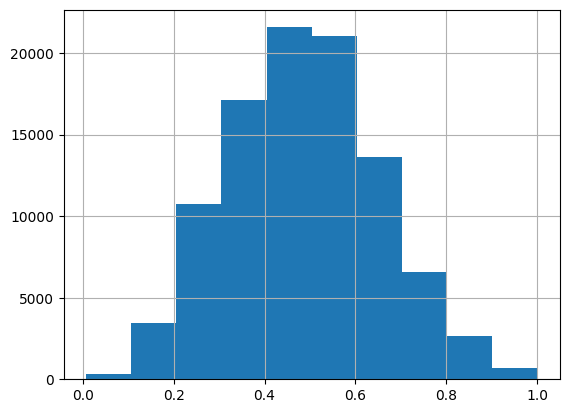

In [31]:
data.moody_sc.hist()

<Axes: >

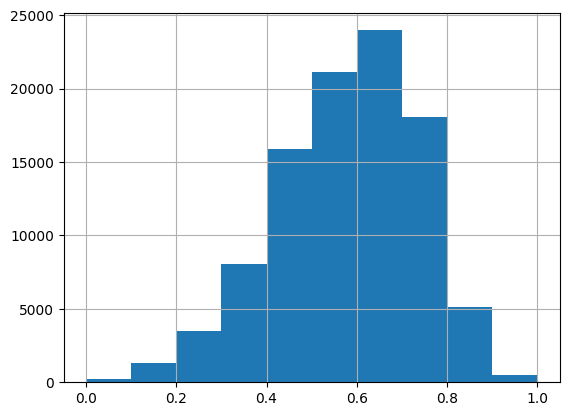

In [21]:
data.fancy_sc.hist()

<Axes: >

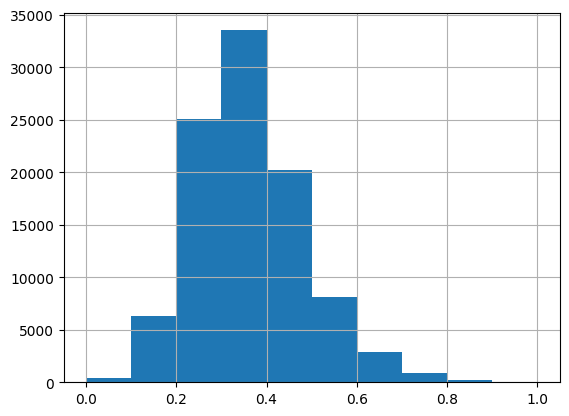

In [20]:
data.romantic_sc.hist()

<Axes: >

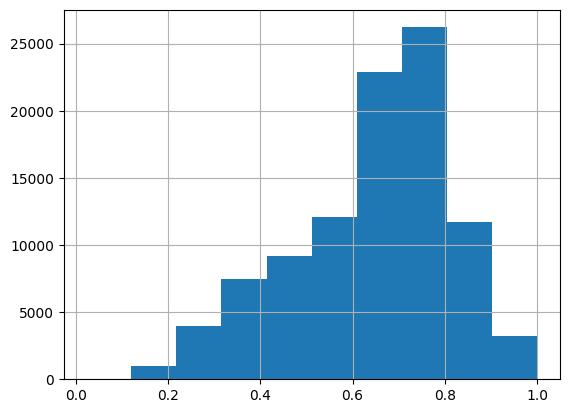

In [33]:
data.casual_sc.hist()

<Axes: >

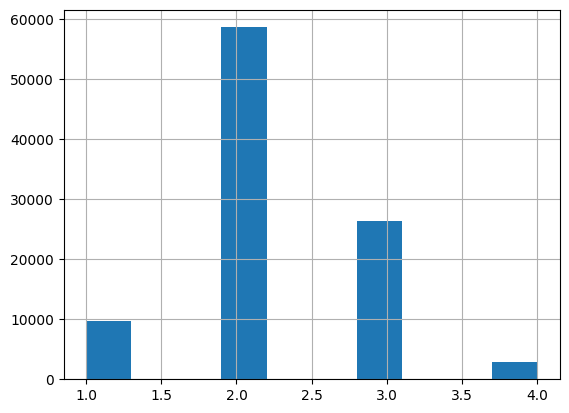

In [37]:
data.romantic_sc_norm.hist()

<Axes: >

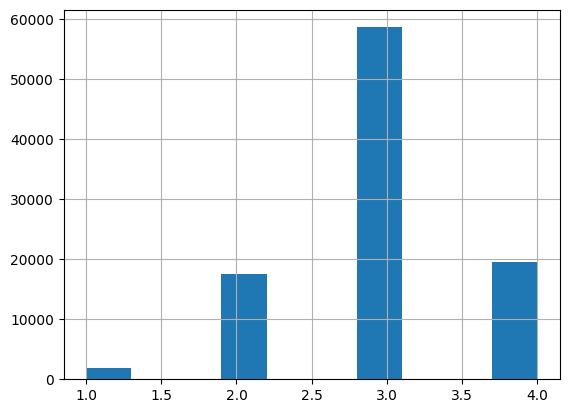

In [36]:
data.fancy_sc_norm.hist()

<Axes: >

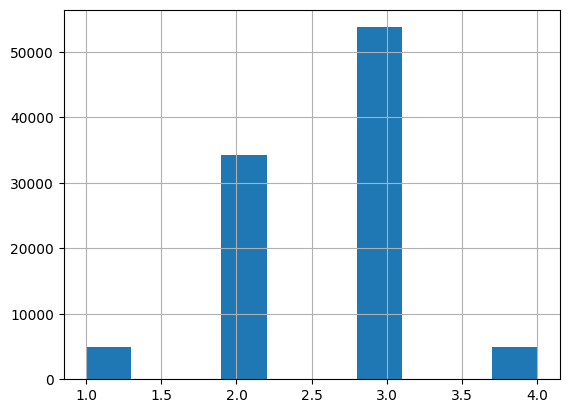

In [35]:
data.moody_sc_norm.hist()

<Axes: >

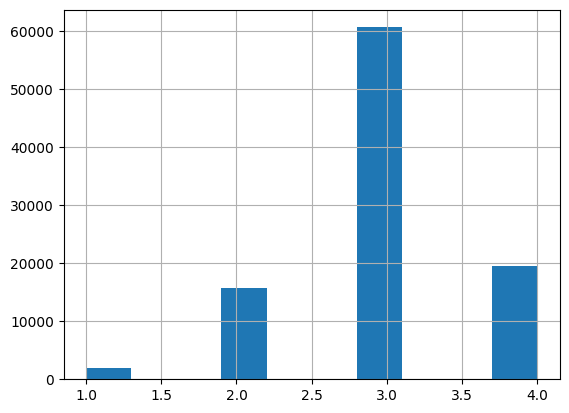

In [34]:
data.casual_sc_norm.hist()

In [83]:
#occasion_attributes
#occasion_attribute_infos
#average_occasion_vecs
#occasion_attributes_distances

occasion_attributes_keys = dict()
for i in occasion_attributes.keys() :
    occasion_attributes_keys[i] = ""

occasion_attributes_keys 

{'romantic': '', 'moody': '', 'casual': '', 'fancy': ''}

In [81]:
data.to_csv("/Users/hyunoochang/code/chyunoo/wineteller/raw_data/scored_data.csv")

In [12]:
data.shape

(97772, 17)

In [1]:
import pandas as pd
test = pd.read_csv("/Users/hyunoochang/code/chyunoo/wineteller/raw_data/scored_data.csv", index_col=0)

In [4]:
print(test.memory_usage(deep=True).sum())

72399410


In [13]:
test.shape

(97772, 13)

In [3]:
test

,country,description,province,variety,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,casual_sc_norm,fancy_sc_norm,moody_sc_norm,avg_sc
0,US,This tremendous 100% varietal wine hails from ...,California,Cabernet Sauvignon,0.330745,0.738717,0.766991,0.756505,2,3,4,3,3.00
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Northern Spain,Tinta de Toro,0.371280,0.787276,0.718395,0.756321,2,3,4,4,3.25
2,US,Mac Watson honors the memory of a wine once ma...,California,Sauvignon Blanc,0.562043,0.588897,0.349290,0.644477,3,2,3,3,2.75
3,US,"This spent 20 months in 30% new French oak, an...",Oregon,Pinot Noir,0.350978,0.653178,0.671331,0.742770,2,3,4,3,3.00
4,France,"This is the top wine from La Bégude, named aft...",Provence,Provence red blend,0.253620,0.882604,0.546203,0.671408,2,3,3,4,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97767,US,A Syrah-Grenache blend that's dry and rustical...,California,Syrah-Grenache,0.241600,0.401484,0.784851,0.526615,2,4,3,2,2.75
97768,Portugal,Oreo eaters will enjoy the aromas of this wine...,Port,Port,0.293042,0.594850,0.629761,0.632411,2,3,3,3,2.75
97769,US,"Outside of the vineyard, wines like this are w...",California,Merlot,0.341960,0.499572,0.733501,0.462067,2,3,3,3,2.75
97770,Argentina,"Heavy and basic, with melon and pineapple arom...",Mendoza Province,Sauvignon Blanc,0.229394,0.562983,0.354721,0.451143,2,2,3,3,2.50


In [77]:
print(data.memory_usage(deep=True).sum())

4382369


In [87]:
data

,country,description,province,variety,romantic_sc,moody_sc,casual_sc,fancy_sc,romantic_sc_norm,casual_sc_norm,fancy_sc_norm,moody_sc_norm,avg_sc
0,US,Cabernet Sauvignon,California,Cabernet Sauvignon,0.330745,0.738717,0.766991,0.756505,2,3,4,3,3.00
1,Spain,Tinta de Toro,Northern Spain,Tinta de Toro,0.371280,0.787276,0.718395,0.756321,2,3,4,4,3.25
2,US,Sauvignon Blanc,California,Sauvignon Blanc,0.562043,0.588897,0.349290,0.644477,3,2,3,3,2.75
3,US,Pinot Noir,Oregon,Pinot Noir,0.350978,0.653178,0.671331,0.742770,2,3,4,3,3.00
4,France,Provence red blend,Provence,Provence red blend,0.253620,0.882604,0.546203,0.671408,2,3,3,4,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97767,US,Syrah-Grenache,California,Syrah-Grenache,0.241600,0.401484,0.784851,0.526615,2,4,3,2,2.75
97768,Portugal,Port,Port,Port,0.293042,0.594850,0.629761,0.632411,2,3,3,3,2.75
97769,US,Merlot,California,Merlot,0.341960,0.499572,0.733501,0.462067,2,3,3,3,2.75
97770,Argentina,Sauvignon Blanc,Mendoza Province,Sauvignon Blanc,0.229394,0.562983,0.354721,0.451143,2,2,3,3,2.50


In [ ]:
dtype_dict = {
    'column1': 'int32',
    'column2': 'float32',
    'column3': 'object',  # or specify 'str' if it's purely strings
    # Add more columns as needed
}